In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score,RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import  make_scorer,accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
import plotly.express as px
import plotly.io as pio
from skopt import BayesSearchCV
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    classification_report
)
import warnings
from skopt.space import Real, Integer, Categorical
warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
df = pd.read_csv('new_retail_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
data = df[df['Date'].dt.year == 2024].copy()
data['Month'] = data['Date'].dt.month
print(df.shape)
print(data.shape)
print(data.info())

(302010, 30)
(49800, 30)
<class 'pandas.core.frame.DataFrame'>
Index: 49800 entries, 4 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    49735 non-null  float64       
 1   Customer_ID       49744 non-null  float64       
 2   Name              49730 non-null  object        
 3   Email             49752 non-null  object        
 4   Phone             49741 non-null  float64       
 5   Address           49754 non-null  object        
 6   City              49760 non-null  object        
 7   State             49750 non-null  object        
 8   Zipcode           49744 non-null  float64       
 9   Country           49751 non-null  object        
 10  Age               49778 non-null  float64       
 11  Gender            49760 non-null  object        
 12  Income            49750 non-null  object        
 13  Customer_Segment  49758 non-null  object        
 14  D

# Data Cleaning

In [4]:
#Calculating missing value percentage
data.isnull().sum()/len(df)*100

Transaction_ID      0.021522
Customer_ID         0.018542
Name                0.023178
Email               0.015894
Phone               0.019536
Address             0.015231
City                0.013245
State               0.016556
Zipcode             0.018542
Country             0.016225
Age                 0.007285
Gender              0.013245
Income              0.016556
Customer_Segment    0.013907
Date                0.000000
Year                0.016225
Month               0.000000
Time                0.019536
Total_Purchases     0.017218
Amount              0.018874
Total_Amount        0.018874
Product_Category    0.013576
Product_Brand       0.015231
Product_Type        0.000000
Feedback            0.012251
Shipping_Method     0.017218
Payment_Method      0.017218
Order_Status        0.013907
Ratings             0.012251
products            0.000000
dtype: float64

In [5]:
#Checking for duplicate records
data.duplicated().sum()

0

In [6]:
data.dropna(inplace=True)
print(data.shape)

(48573, 30)


In [7]:
# Both variables are inherently discrete, and converting them to integers helps save memory. 
data['Age'] = data['Age'].astype(int)
data['Total_Purchases'] = data['Total_Purchases'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48573 entries, 4 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    48573 non-null  float64       
 1   Customer_ID       48573 non-null  float64       
 2   Name              48573 non-null  object        
 3   Email             48573 non-null  object        
 4   Phone             48573 non-null  float64       
 5   Address           48573 non-null  object        
 6   City              48573 non-null  object        
 7   State             48573 non-null  object        
 8   Zipcode           48573 non-null  float64       
 9   Country           48573 non-null  object        
 10  Age               48573 non-null  int64         
 11  Gender            48573 non-null  object        
 12  Income            48573 non-null  object        
 13  Customer_Segment  48573 non-null  object        
 14  Date              48573 no

In [8]:
data.head()

Transaction_ID  Customer_ID               Name                Email  \
4        4983775.0      27901.0      Debra Coleman  Charles30@gmail.com   
8        4155845.0      80175.0        Diane Clark   Martin39@gmail.com   
12       2846832.0      31930.0  Kristine Williams  Charles29@gmail.com   
18       7728099.0      78376.0        Ronald Chen   Nicole72@gmail.com   
22       9476855.0      42410.0  Anthony Rodriguez    Paula49@gmail.com   

           Phone                       Address        City            State  \
4   9.098268e+09     5813 Lori Ports Suite 269     Bristol          England   
8   6.219780e+09  8823 Mariah Heights Apt. 263  Wollongong  New South Wales   
12  1.822768e+09          60629 Jones Villages  Portsmouth          England   
18  1.796133e+09             6048 Charles Lake  Portsmouth          England   
22  3.745118e+09     585 Malik Lodge Suite 186  Portsmouth          England   

    Zipcode    Country  ...  Total_Amount Product_Category  Product_Brand  \
4   48704.0         UK  ...    248.553049          Grocery         Nestle   
8   39820.0  Australia  ...   2630.714413          Grocery         Nestle   
12  38173.0         UK  ...   1618.793610          Grocery      Coca-Cola   
18  82975.0         UK  ...    210.137919          Grocery      Coca-Cola   
22  83903.0         UK  ...    204.745598            Books  Penguin Books   

   Product_Type Feedback  Shipping_Method  Payment_Method Order_Status  \
4     Chocolate      Bad         Standard            Cash      Shipped   
8     Chocolate      Bad         Same-Day            Cash    Delivered   
12        Water      Bad         Standard          PayPal    Delivered   
18        Juice      Bad          Express     Credit Card      Shipped   
22  Non-Fiction  Average         Same-Day          PayPal   Processing   

    Ratings           products  
4       1.0  Chocolate cookies  
8       1.0     Dark chocolate  
12      1.0      Bottled water  
18      1.0       Orange juice  
22      2.0          Self-help  

[5 rows x 30 columns]

# Exploratory Data Analysis


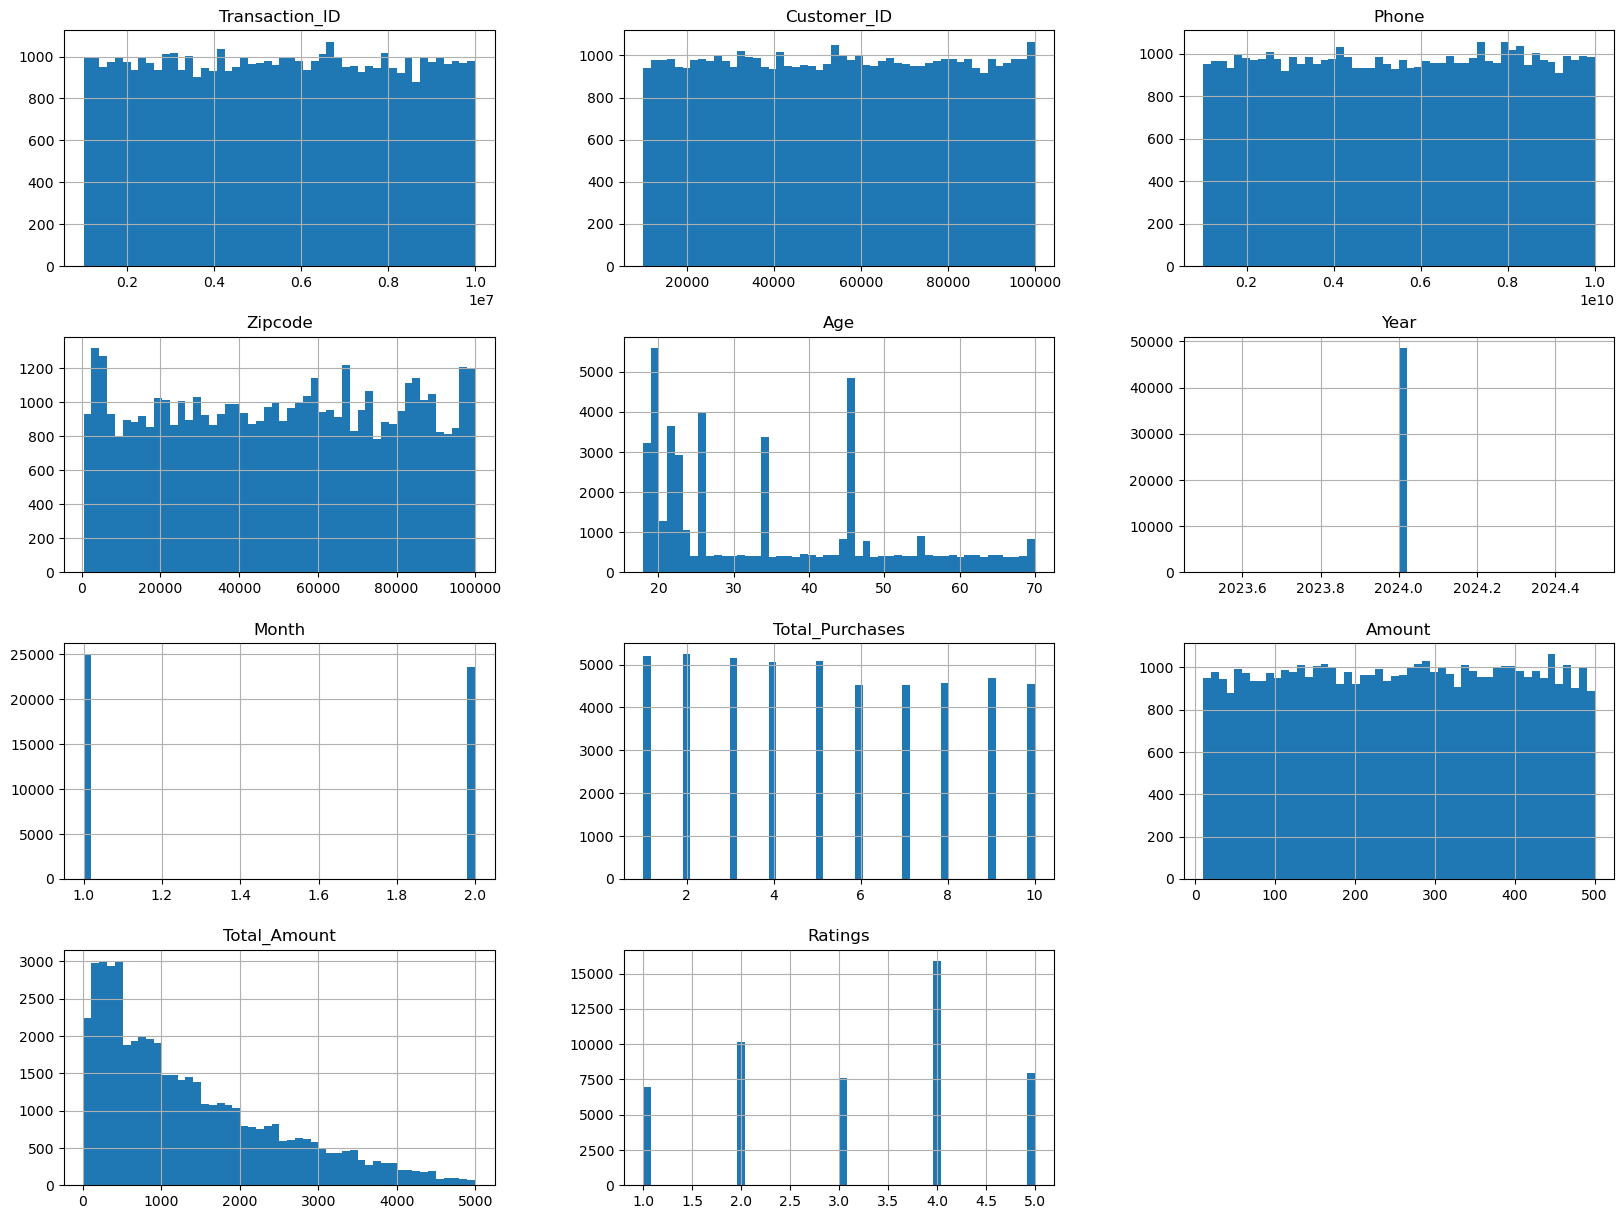

In [9]:
# Visualize the distribution of numeric features
numeric_cols = data.select_dtypes(include=['float64','int32','int64']).columns
data[numeric_cols].hist(bins=50, figsize=(20,15))
plt.savefig('numeric_features_combined.png')
plt.show()

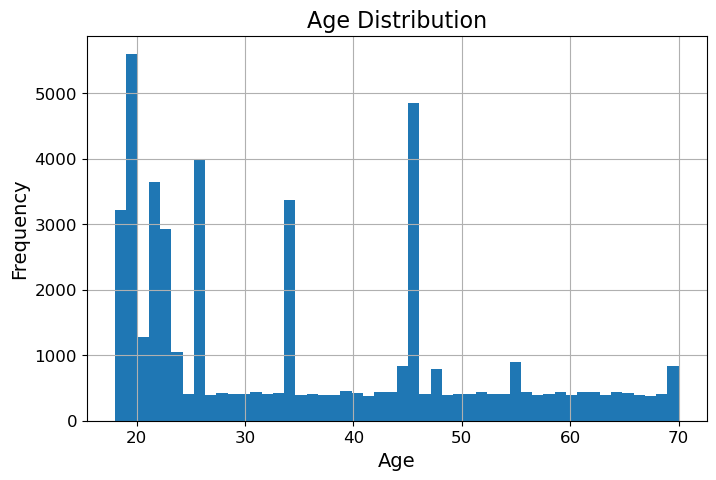

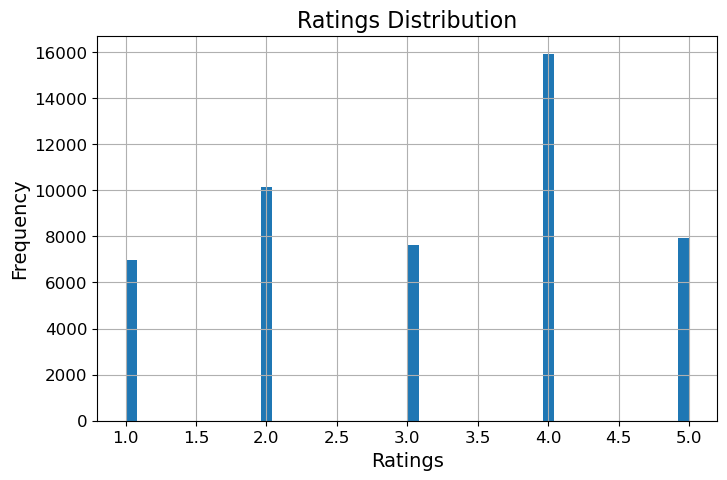

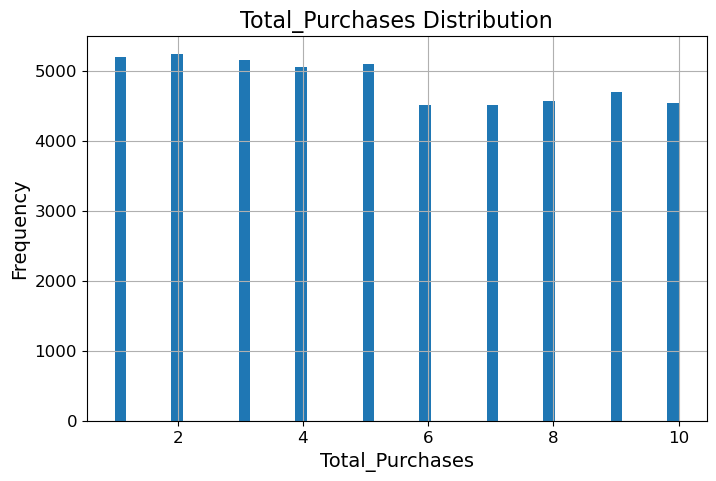

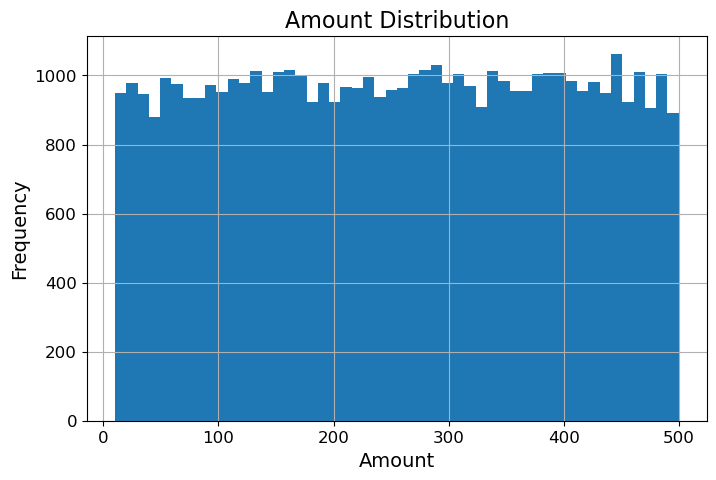

In [13]:
# Create separate visualizations for selected features
selected_features = ['Age', 'Ratings', 'Total_Purchases', 'Amount']

for feature in selected_features:
    plt.figure(figsize=(8, 5))
    data[feature].hist(bins=50)
    plt.title(f'{feature} Distribution', fontsize=16)  # Increase title font size
    plt.xlabel(feature, fontsize=14)  # Increase X axis label font size
    plt.ylabel('Frequency', fontsize=14)  # Increase Y axis label font size
    plt.xticks(fontsize=12)  # Increase X axis tick font size
    plt.yticks(fontsize=12)  # Increase Y axis tick font size
    plt.savefig(f'{feature}_distribution.png')
    plt.show()

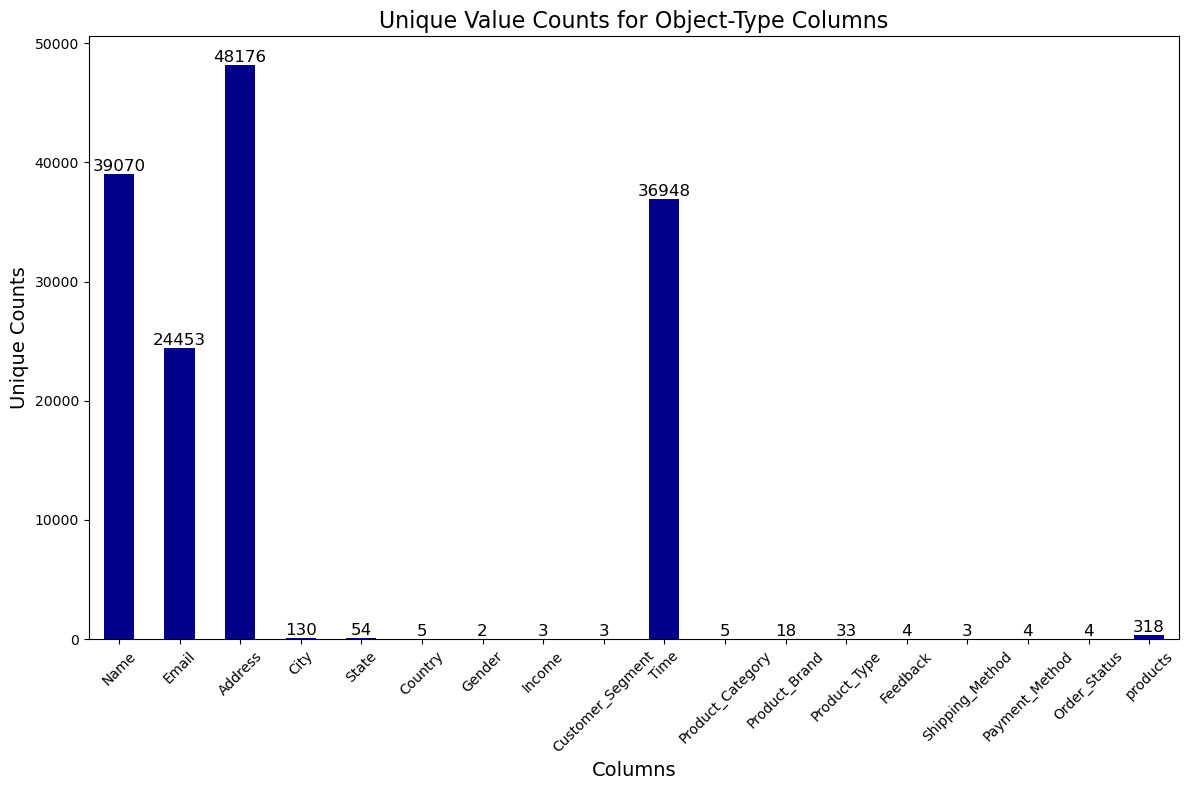

In [9]:
# Plot the unique counts of object-type columns
plt.figure(figsize=(12, 8))  # Increased figure size
ax = data.select_dtypes(include=['object']).nunique().plot(
    kind='bar',
    color='darkblue',  # Darker blue color
    rot=45  # Rotate x-axis labels for readability
)

# Add value labels on top of the bars
ax.bar_label(ax.containers[0], fontsize=12)

# Add title and labels
plt.title('Unique Value Counts for Object-Type Columns', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Unique Counts', fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("unique_counts_object_columns.png")
plt.show()


Feedback Distribution:
Feedback
Excellent    16187
Good         15265
Average      10134
Bad           6987
Name: count, dtype: int64


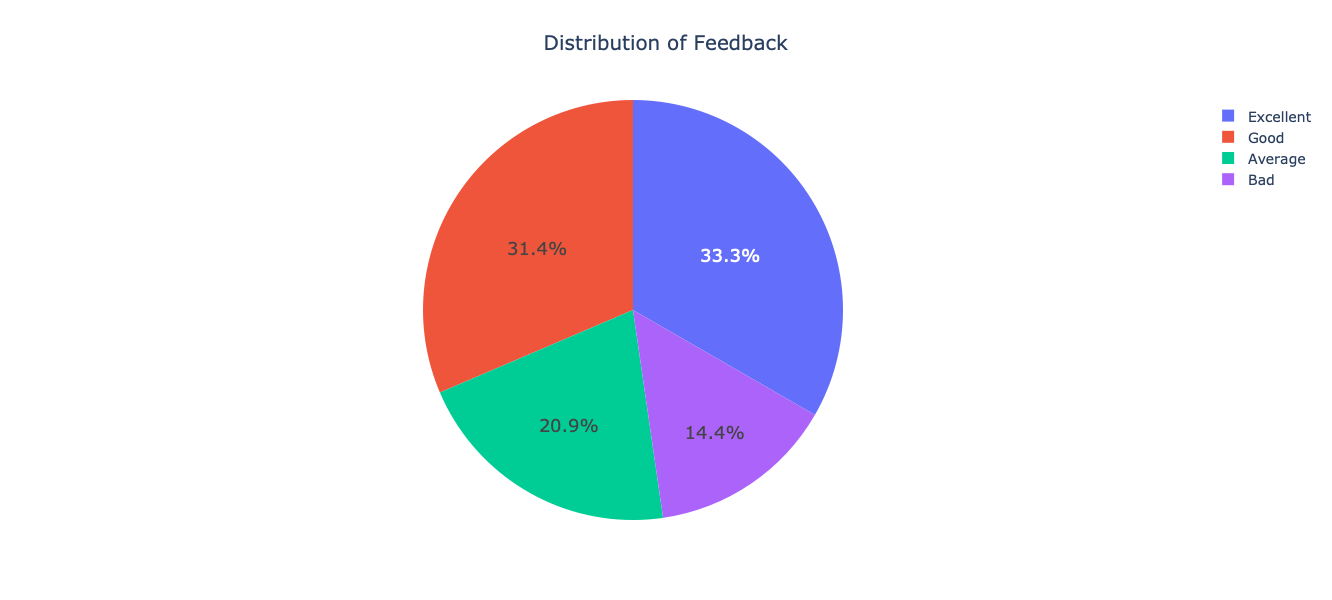

In [10]:
# Target variable analysis
print("\nFeedback Distribution:")
feedback_dist = data['Feedback'].value_counts()
print(feedback_dist)

# Create the pie chart
fig = px.pie(
    data, 
    names='Feedback', 
    title='Distribution of Feedback'
)

# Update layout for larger figure and better fonts
fig.update_traces(
    textinfo='percent',      # Show only percentages inside the pie
    textfont_size=18         # Increase font size for percentage labels
)
fig.update_layout(
    width=800,               # Set width for larger chart
    height=600,              # Set height for larger chart
    title={
        'text': 'Distribution of Feedback',
        'x': 0.5,            # Center the title
        'xanchor': 'center',
        'font': {'size': 20} # Increase font size of the title
    },
    legend={
        'font': {'size': 14} # Increase legend font size
    }
)

# Show and save the plot
fig.show()
fig.write_image("Feedback_distribution.png")

                Age
count  48573.000000
mean      35.389558
std       14.997635
min       18.000000
25%       22.000000
50%       32.000000
75%       46.000000
max       70.000000


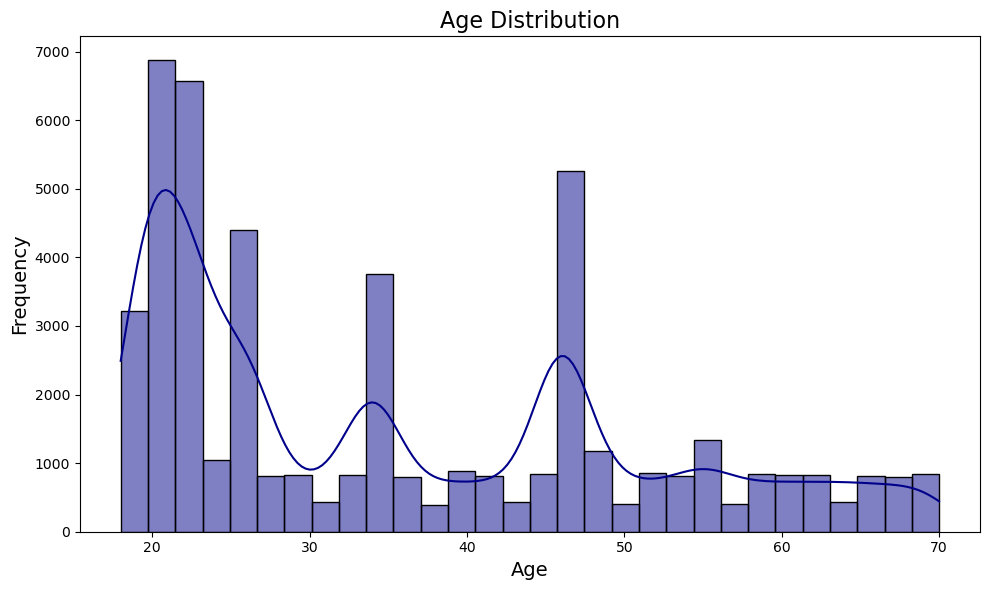

In [11]:
# Summary statistics for age 
print(data[['Age']].describe())
# Visualize age distributions
# Set figure size for a larger plot
plt.figure(figsize=(10, 6))  # Increase the width and height of the figure

# Plot the histogram with a density estimate (kde)
sns.histplot(data['Age'], kde=True, color="darkblue", bins=30)

# Add title and labels
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('age_distribution.png')

# Show the plot
plt.show()

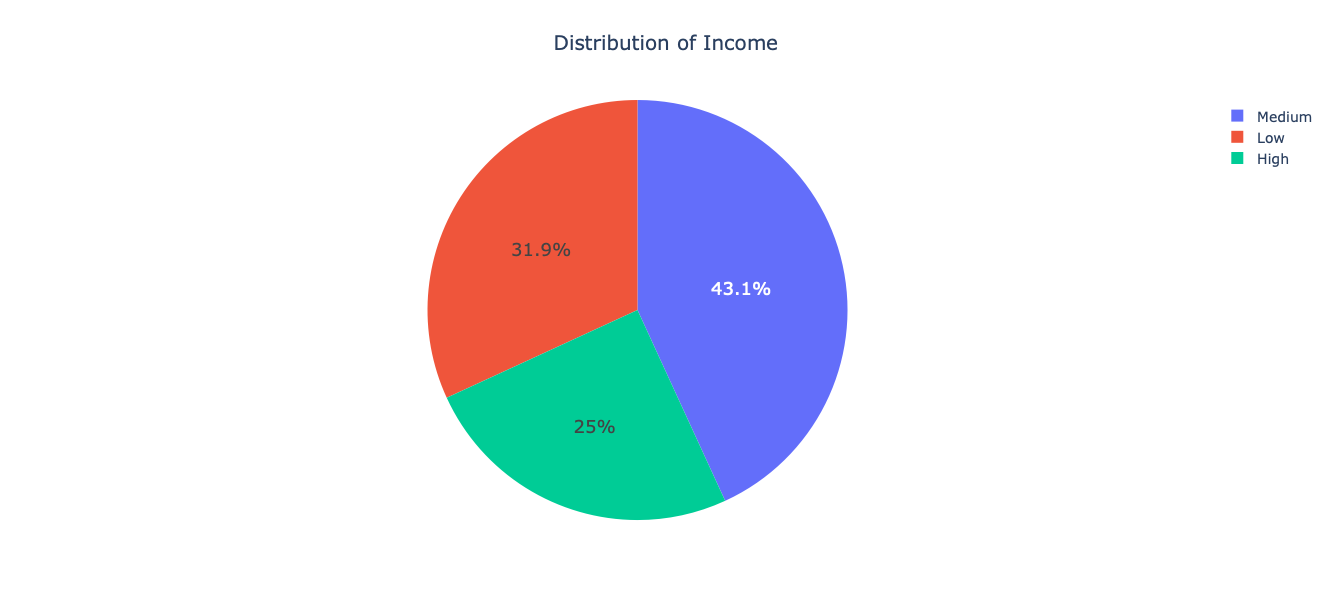

In [12]:
import plotly.express as px

# Create the pie chart
fig = px.pie(
    data, 
    names='Income', 
    title='Distribution of Income'
)

# Update layout for larger figure and better fonts
fig.update_traces(
    textinfo='percent',      # Show only percentages inside the pie
    textfont_size=18         # Increase font size for percentage labels
)
fig.update_layout(
    width=800,               # Set width for larger chart
    height=600,              # Set height for larger chart
    title={
        'text': 'Distribution of Income',
        'x': 0.5,            # Center the title
        'xanchor': 'center',
        'font': {'size': 20} # Increase font size of the title
    },
    legend={
        'font': {'size': 14} # Increase legend font size
    }
)

# Show and save the plot
fig.show()
fig.write_image("income_distribution.png")

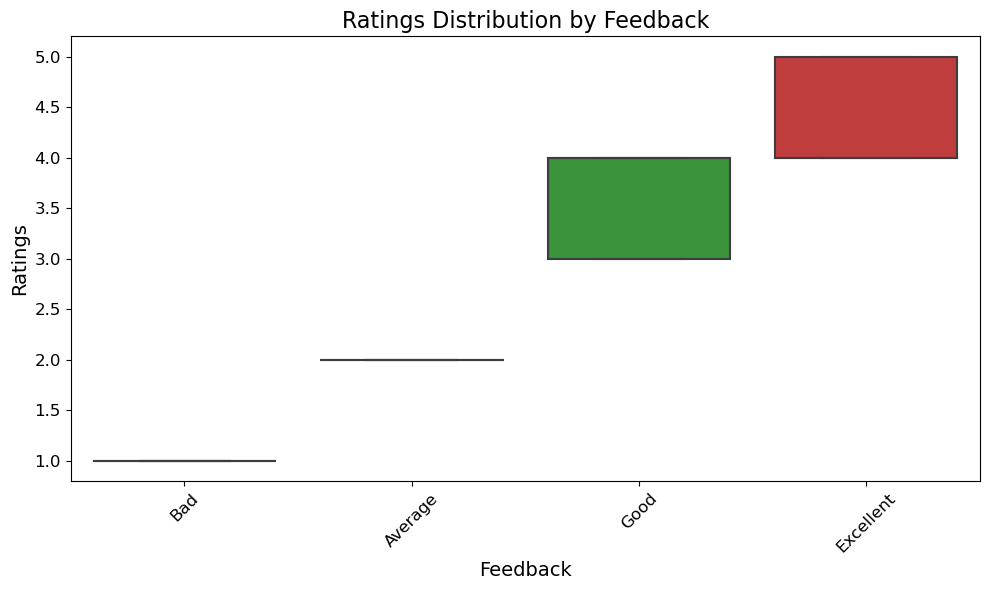

In [13]:
# Average Ratings by Feedback
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=data, x='Feedback', y='Ratings')

# Add a title and adjust font sizes
plt.title('Ratings Distribution by Feedback', fontsize=16)  # Title font size
plt.xlabel('Feedback', fontsize=14)  # X-axis label font size
plt.ylabel('Ratings', fontsize=14)  # Y-axis label font size

# Rotate x-axis labels and adjust their font size
plt.xticks(rotation=45, fontsize=12)  # Rotate and set font size for x-axis
plt.yticks(fontsize=12)  # Adjust font size for y-axis

# Adjust layout for better spacing
plt.tight_layout()

# Show and save the plot
plt.savefig('rating_vs_feedback.png')
plt.show()

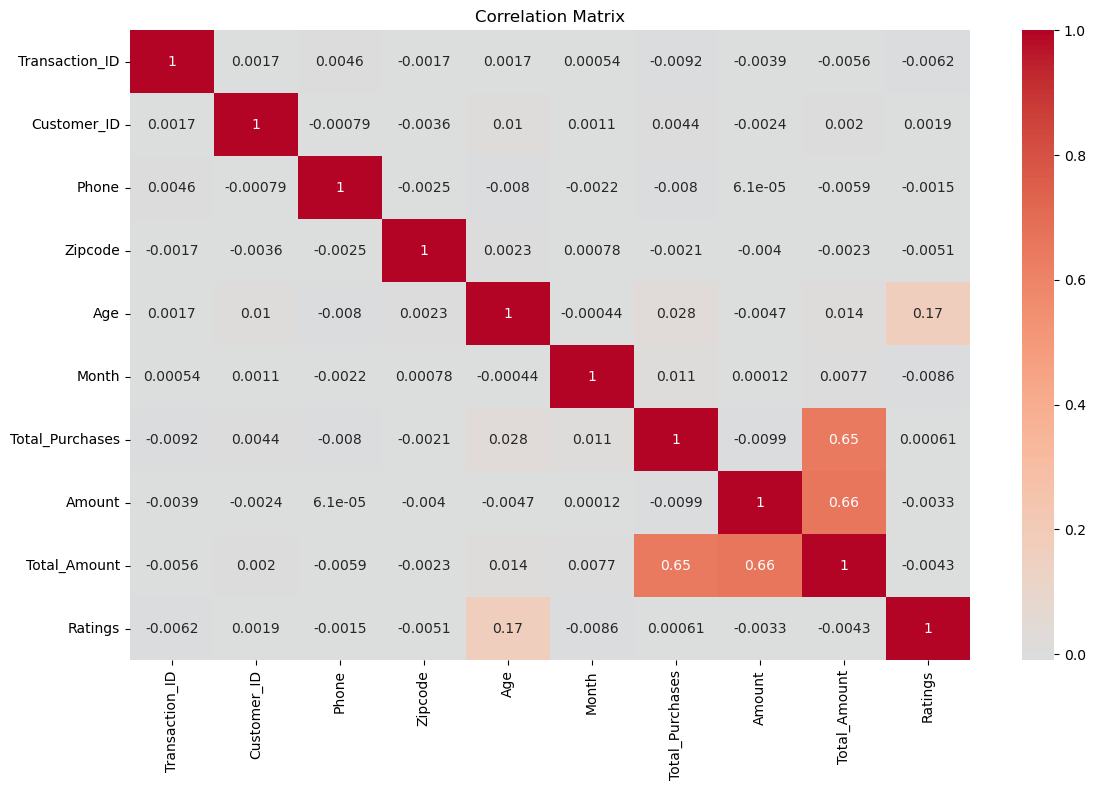

In [14]:
# Correlation between numeric variables
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('Year')
correlation = data[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

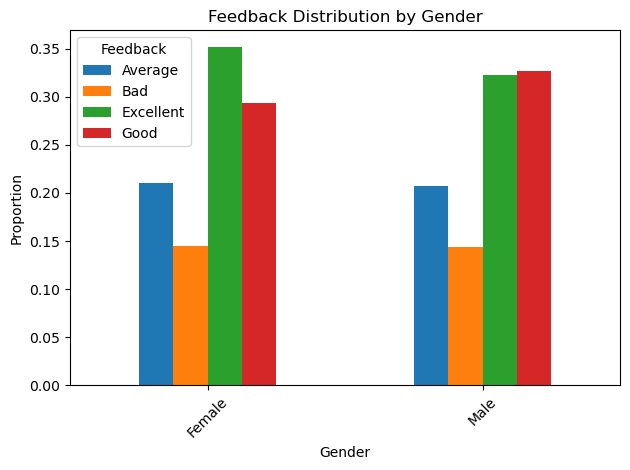

<Figure size 1000x600 with 0 Axes>

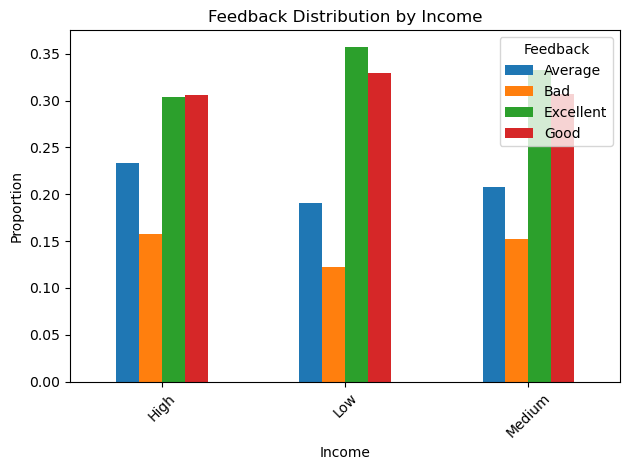

<Figure size 1000x600 with 0 Axes>

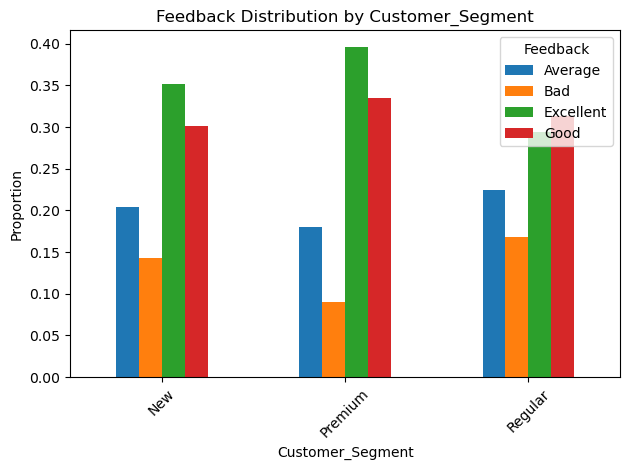

<Figure size 1000x600 with 0 Axes>

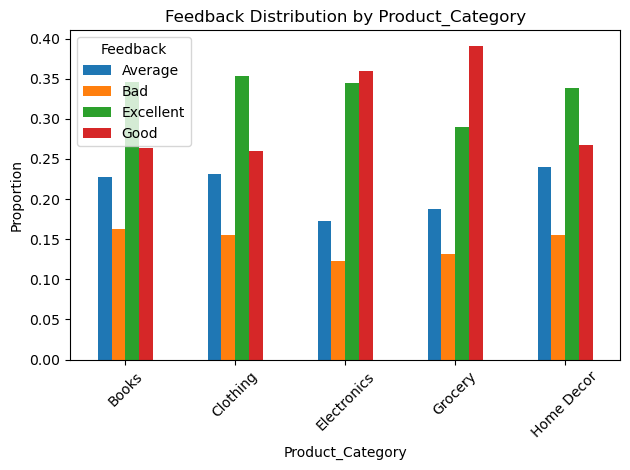

<Figure size 1000x600 with 0 Axes>

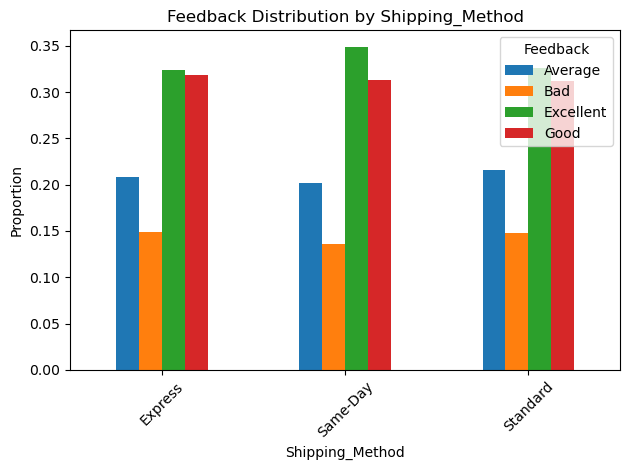

<Figure size 1000x600 with 0 Axes>

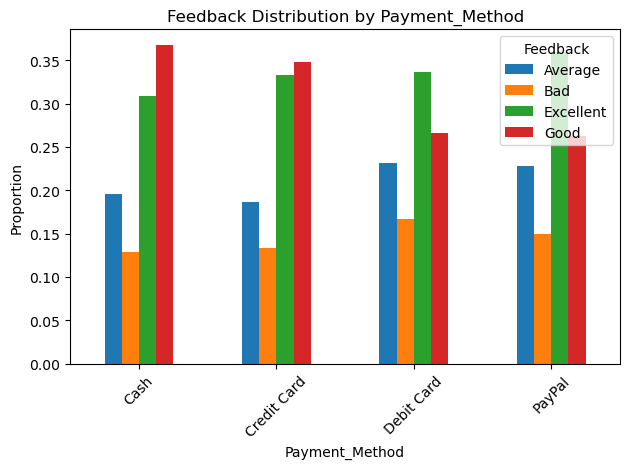

<Figure size 1000x600 with 0 Axes>

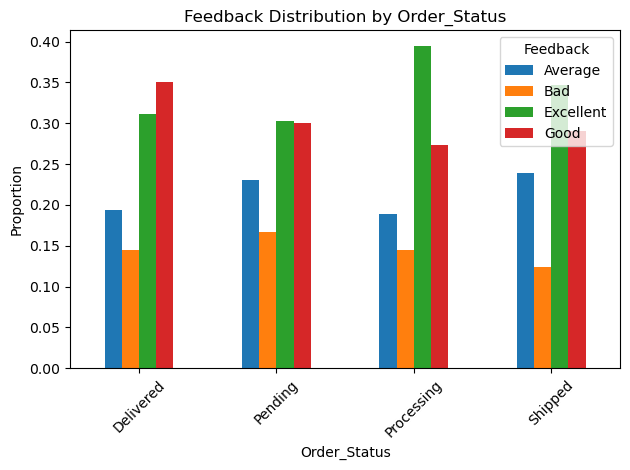

In [15]:
# Feature importance analysis using categorical variables
categorical_cols = ['Gender', 'Income','Customer_Segment', 'Product_Category', 'Shipping_Method', 'Payment_Method', 'Order_Status']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    pd.crosstab(data[col], data['Feedback'], normalize='index').plot(kind='bar')
    plt.title(f'Feedback Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.legend(title='Feedback')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Save the figure with a dynamic filename
    filename = f'feedback_distribution_by_{col}.png'
    plt.savefig(filename)    
    # Show the plot
    plt.show()
    plt.show()

<Figure size 1000x600 with 0 Axes>

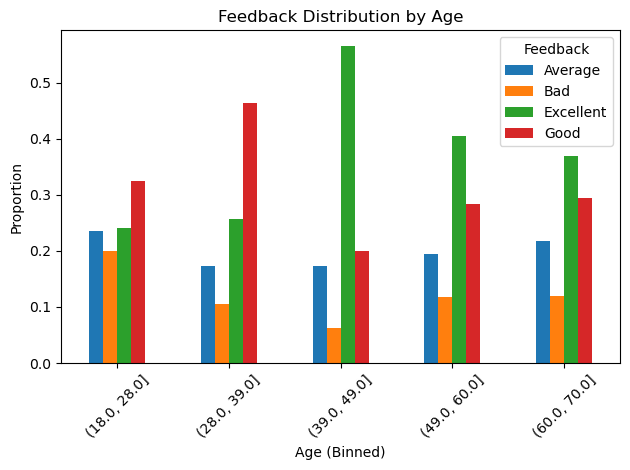

<Figure size 1000x600 with 0 Axes>

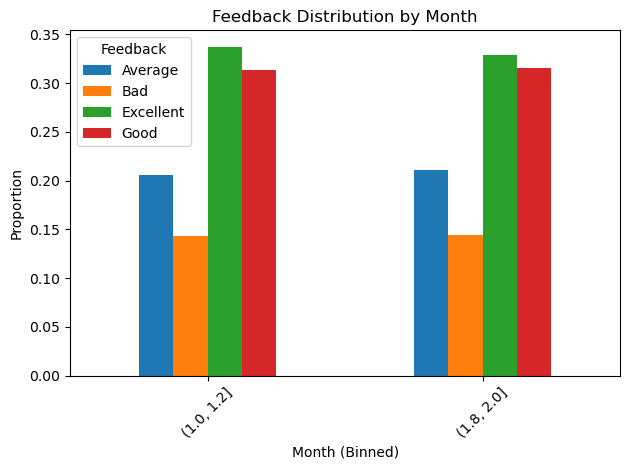

<Figure size 1000x600 with 0 Axes>

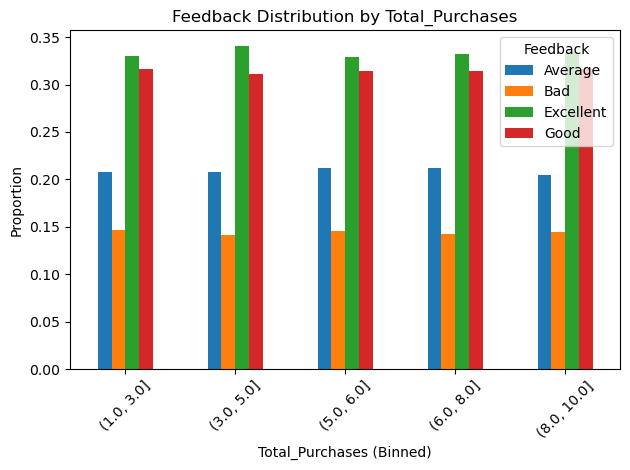

<Figure size 1000x600 with 0 Axes>

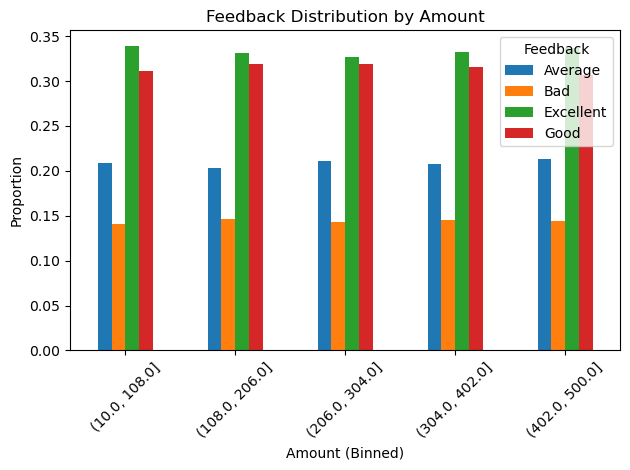

<Figure size 1000x600 with 0 Axes>

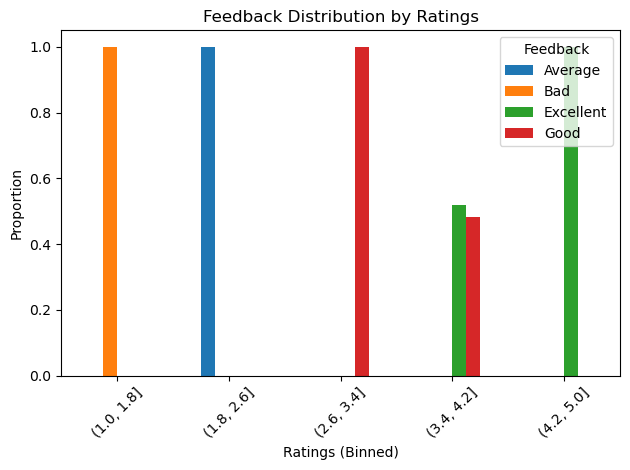

In [16]:
# List of numeric columns to analyze
numeric_cols = ['Age', 'Month', 'Total_Purchases', 'Amount', 'Ratings']

for col in numeric_cols:
    # Discretize (bin) the numeric column
    binned_col = pd.cut(data[col], bins=5, precision=0) 

    # Create a crosstab with 'Feedback'
    plt.figure(figsize=(10, 6))
    pd.crosstab(binned_col, data['Feedback'], normalize='index').plot(kind='bar')
    
    # Add titles and labels
    plt.title(f'Feedback Distribution by {col}')
    plt.xlabel(f'{col} (Binned)')
    plt.ylabel('Proportion')
    plt.legend(title='Feedback')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the figure with a dynamic filename
    filename = f'feedback_distribution_by_{col}.png'
    plt.savefig(filename)
    
    # Show the plot
    plt.show()


# Feature Engineering


## Feature Creation



In [8]:
#create RFM
latest_date = data['Date'].max()
data['Recency'] = (latest_date - data['Date']).dt.days
data['Frequency'] = data.groupby('Customer_ID')['Transaction_ID'].transform('count')
data['Monetary'] = data.groupby('Customer_ID')['Total_Amount'].transform('sum')

#create time_of_day
data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'
data['Time_of_Day'] = data['Hour'].apply(assign_time_of_day)

In [9]:
#after feature creation, some irrelevant features can be deleted
irrelevant_features = ['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'Zipcode', 'Year','Total_Amount','Time','Date','Hour','products','Ratings']
data.drop(columns=[col for col in irrelevant_features if col in data.columns], inplace=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48573 entries, 4 to 302009
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              48573 non-null  object 
 1   State             48573 non-null  object 
 2   Country           48573 non-null  object 
 3   Age               48573 non-null  int64  
 4   Gender            48573 non-null  object 
 5   Income            48573 non-null  object 
 6   Customer_Segment  48573 non-null  object 
 7   Month             48573 non-null  int32  
 8   Total_Purchases   48573 non-null  int64  
 9   Amount            48573 non-null  float64
 10  Product_Category  48573 non-null  object 
 11  Product_Brand     48573 non-null  object 
 12  Product_Type      48573 non-null  object 
 13  Feedback          48573 non-null  object 
 14  Shipping_Method   48573 non-null  object 
 15  Payment_Method    48573 non-null  object 
 16  Order_Status      48573 non-null  object 
 1

## Feature Encoding

In [10]:
data_encoded = data.copy()
# Step 1: Define revised ordinal mapping for 'Income' and 'Feedback'
income_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
feedback_mapping = {'Bad': 0, 'Average': 1, 'Good': 2, 'Excellent': 3}

# Step 2: Apply mappings to encode 'Income' and 'Feedback' in the original DataFrame
data_encoded['Income'] = data['Income'].map(income_mapping)
data_encoded['Feedback'] = data['Feedback'].map(feedback_mapping)

# Step 3: Create interaction term between 'Age' and encoded 'Income'
data_encoded['Age_Income_Interaction'] = data['Age'] * data_encoded['Income']

# Perform frequency encoding on high cardinality categorical variables
high_cardinality_cols = ['Product_Brand', 'Product_Type', 'City', 'State']
for col in high_cardinality_cols:
    freq_encoding = data[col].value_counts() / len(data)
    data_encoded[col + '_freq'] = data[col].map(freq_encoding)

# Use Binary Encoding for high cardinality variables
binary_encoder = ce.BinaryEncoder(cols=high_cardinality_cols + [col + '_freq' for col in high_cardinality_cols])
data_encoded = binary_encoder.fit_transform(data_encoded)

# Use One-Hot Encoding for low cardinality categorical variables
data_encoded = pd.get_dummies(data_encoded, columns=[
    'Gender', 'Customer_Segment', 'Product_Category','Country',
    'Shipping_Method', 'Payment_Method', 'Order_Status', 'Time_of_Day'
], drop_first=True)

print(data_encoded.shape)
print(data_encoded.head())

(48573, 80)
    City_0  City_1  City_2  City_3  City_4  City_5  City_6  City_7  State_0  \
4        0       0       0       0       0       0       0       1        0   
8        0       0       0       0       0       0       1       0        0   
12       0       0       0       0       0       0       1       1        0   
18       0       0       0       0       0       0       1       1        0   
22       0       0       0       0       0       0       1       1        0   

    State_1  ...  Shipping_Method_Standard  Payment_Method_Credit Card  \
4         0  ...                      True                       False   
8         0  ...                     False                       False   
12        0  ...                      True                       False   
18        0  ...                     False                        True   
22        0  ...                     False                       False   

    Payment_Method_Debit Card  Payment_Method_PayPal  Order_Status_P

# Data Spliting & Scaling

In [11]:
X = data_encoded.drop(columns=['Feedback'])
y = data_encoded['Feedback']

# Split the dataset into training + validation set (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardization
scaler = StandardScaler()

# Fit and transform the training set
X_train = scaler.fit_transform(X_train)

# Apply the scaling rules from the training set to the validation and test sets
X_test = scaler.transform(X_test)


# Feature Selection

Validation Scores per Number of Features:
1 Features: 0.2537
2 Features: 0.2482
3 Features: 0.2443
4 Features: 0.3238
5 Features: 0.3291
6 Features: 0.3292
7 Features: 0.3294
8 Features: 0.3316
9 Features: 0.3338
10 Features: 0.3380
11 Features: 0.3324
12 Features: 0.3340
13 Features: 0.3346
14 Features: 0.3331
15 Features: 0.3329
16 Features: 0.3385
17 Features: 0.3387
18 Features: 0.3400
19 Features: 0.3383
20 Features: 0.3402
21 Features: 0.3415
22 Features: 0.3424
23 Features: 0.3399
24 Features: 0.3425
25 Features: 0.3448
26 Features: 0.3448
27 Features: 0.3428
28 Features: 0.3457
29 Features: 0.3427
30 Features: 0.3434
31 Features: 0.3457
32 Features: 0.3447
33 Features: 0.3440
34 Features: 0.3470
35 Features: 0.3499
36 Features: 0.3511
37 Features: 0.3496
38 Features: 0.3480
39 Features: 0.3462
40 Features: 0.3454
41 Features: 0.3438
42 Features: 0.3474
43 Features: 0.3461
44 Features: 0.3458
45 Features: 0.3472
46 Features: 0.3441
47 Features: 0.3448
48 Features: 0.3412
49 Feat

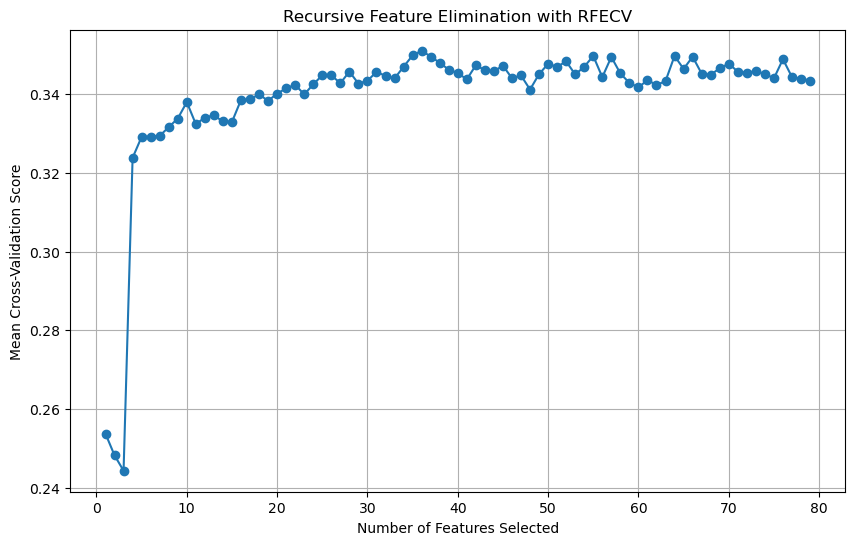

Optimal Features: ['City_2', 'City_3', 'City_4', 'City_5', 'State_5', 'Age', 'Income', 'Month', 'Total_Purchases', 'Amount', 'Product_Brand_0', 'Product_Brand_3', 'Product_Type_1', 'Product_Type_2', 'Product_Type_3', 'Product_Type_4', 'Product_Type_5', 'Recency', 'Frequency', 'Monetary', 'Age_Income_Interaction', 'Product_Brand_freq_1', 'Product_Brand_freq_2', 'Product_Brand_freq_4', 'Product_Type_freq_4', 'City_freq_3', 'City_freq_5', 'State_freq_4', 'Gender_Male', 'Shipping_Method_Same-Day', 'Shipping_Method_Standard', 'Payment_Method_Credit Card', 'Order_Status_Shipped', 'Time_of_Day_Evening', 'Time_of_Day_Morning', 'Time_of_Day_Night']
36


In [12]:
# Define the model
rf_model = RandomForestClassifier(random_state=42)

#Use RFECV to do feature election
rfecv = RFECV(estimator=rf_model, step=1, cv=3, scoring='f1_macro', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Print the score on the validation set
print("Validation Scores per Number of Features:")
for n_features, score in zip(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score']):
    print(f"{n_features} Features: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.title("Recursive Feature Elimination with RFECV")
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean Cross-Validation Score")
plt.grid()
plt.savefig(f"RFECV.png", dpi=300)
plt.show()

original_column_names = X.columns.tolist() 

# Print the optimal features
optimal_features = [original_column_names[i] for i, selected in enumerate(rfecv.support_) if selected]
print(f"Optimal Features: {optimal_features}")
print(len(optimal_features))

In [13]:
X_train_selected = X_train[:, rfecv.support_]
X_test_selected = X_test[:, rfecv.support_]

# Experiment 1: SMOTE-Tomek

In [14]:
def evaluate_model(X_train_selected, y_train, X_test_selected, y_test, model, model_name="Model", scoring=None, use_resampling=False, cv_splits=3, random_state=42):
    """
    Evaluates a single model with cross-validation and test data performance metrics,
    and dynamically generates confusion matrix specific to the model.
    """
    # Default scoring metrics if not provided
    if scoring is None:
        scoring = {
            'accuracy': 'accuracy',
            'balanced_accuracy': make_scorer(balanced_accuracy_score),
            'precision_macro': make_scorer(precision_score, average='macro'),
            'recall_macro': make_scorer(recall_score, average='macro'),
            'f1_macro': make_scorer(f1_score, average='macro'),
            'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True),
        }

    # Define cross-validation object
    stratified_kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create pipeline with or without SMOTETomek
    if use_resampling:
        print("\nApplying SMOTE-Tomek for resampling...")
        pipeline = Pipeline(steps=[
            ('smote_tomek', SMOTETomek(random_state=random_state)),
            ('model', model)
        ])
    else:
        print("\nUsing original training data (no resampling)...")
        pipeline = Pipeline(steps=[('model', model)])

    # Perform cross-validation
    print("\nPerforming Cross-Validation...")
    cv_results = cross_validate(pipeline, X_train_selected, y_train, cv=stratified_kfold, scoring=scoring, n_jobs=-1)

    # Display cross-validation results
    print("Cross-Validation Metrics:")
    print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"Balanced Accuracy: {cv_results['test_balanced_accuracy'].mean():.4f}")
    print(f"Macro Precision: {cv_results['test_precision_macro'].mean():.4f}")
    print(f"Macro Recall: {cv_results['test_recall_macro'].mean():.4f}")
    print(f"Macro F1-Score: {cv_results['test_f1_macro'].mean():.4f}")
    print(f"Macro AUC-ROC: {cv_results['test_roc_auc'].mean():.4f}")


    # Train the model on the full training data
    print("\nFitting the model on the full training data...")
    pipeline.fit(X_train_selected, y_train)

    # Evaluate the model on the test data
    print("\nEvaluating on the Test Data...")
    y_test_pred = pipeline.predict(X_test_selected)
    y_test_proba = pipeline.predict_proba(X_test_selected)

    # Compute evaluation metrics on the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    test_macro_precision = precision_score(y_test, y_test_pred, average='macro')
    test_macro_recall = recall_score(y_test, y_test_pred, average='macro')
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
    test_auc_roc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')

    # Display test set metrics
    print("\nTest Set Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Balanced Accuracy: {test_balanced_accuracy:.4f}")
    print(f"Macro Precision: {test_macro_precision:.4f}")
    print(f"Macro Recall: {test_macro_recall:.4f}")
    print(f"Macro F1 Score: {test_macro_f1:.4f}")
    print(f"Macro AUC-ROC: {test_auc_roc:.4f}")

    # Print classification report for detailed class-wise results
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Define class labels
    labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Replace with your actual class names

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))  # Adjust figure size
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  # Use 'd' for integer format
                xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='gray', 
                annot_kws={"size": 12, "weight": "normal", "color": "black"})  # Larger, bold text
    plt.title(f"Confusion Matrix of {model_name}", fontsize=18)  # Title size
    plt.xlabel("Predicted Labels", fontsize=14)  # X-axis label size
    plt.ylabel("True Labels", fontsize=14)  # Y-axis label size
    plt.xticks(fontsize=12)  # X-axis tick size
    plt.yticks(fontsize=12)  # Y-axis tick size
    plt.savefig(f"confusion_matrix_{model_name}.png", dpi=300)
    plt.show()

## Before SMOTE-Tomek

### Random Forest


Using original training data (no resampling)...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.4268
Balanced Accuracy: 0.3595
Macro Precision: 0.3642
Macro Recall: 0.3595
Macro F1-Score: 0.3489
Macro AUC-ROC: 0.6725

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.4282
Balanced Accuracy: 0.3613
Macro Precision: 0.3692
Macro Recall: 0.3613
Macro F1 Score: 0.3511
Macro AUC-ROC: 0.6768

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.11      0.16      2096
           1       0.28      0.18      0.22      3040
           2       0.49      0.52      0.50      4580
           3       0.45      0.64      0.53      4856

    accuracy                           0.43     14572
   macro avg       0.37      0.36      0.35     14572
weighted avg       0.40      0.43      0.40     14572



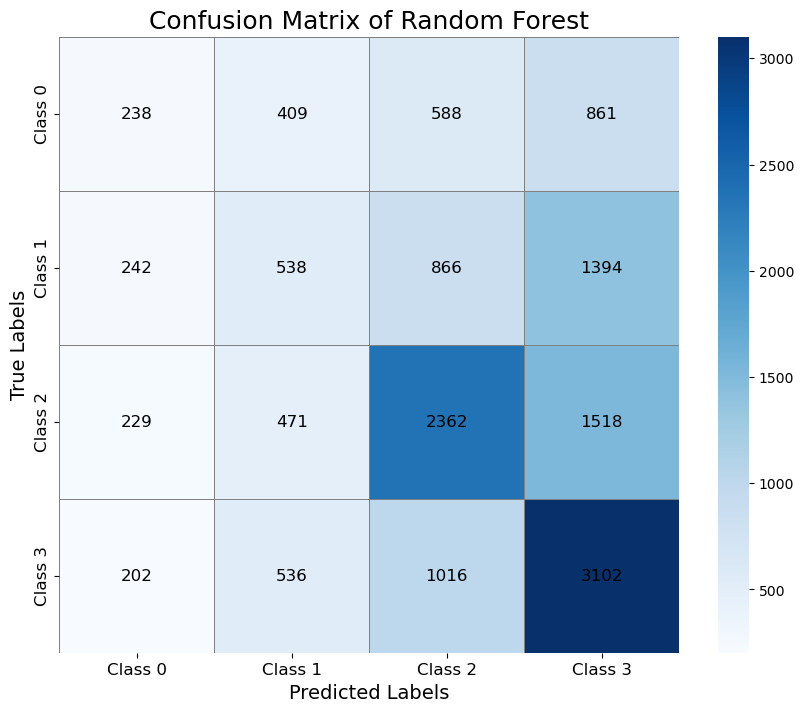

In [15]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
               model=RandomForestClassifier(n_estimators=100, random_state=42), 
               model_name="Random Forest", use_resampling=False)


Using original training data (no resampling)...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.4275
Balanced Accuracy: 0.3568
Macro Precision: 0.3623
Macro Recall: 0.3568
Macro F1-Score: 0.3433
Macro AUC-ROC: 0.6671

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.4317
Balanced Accuracy: 0.3628
Macro Precision: 0.3726
Macro Recall: 0.3628
Macro F1 Score: 0.3515
Macro AUC-ROC: 0.6763

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.11      0.15      2096
           1       0.30      0.18      0.22      3040
           2       0.50      0.50      0.50      4580
           3       0.45      0.67      0.54      4856

    accuracy                           0.43     14572
   macro avg       0.37      0.36      0.35     14572
weighted avg       0.40      0.43      0.40     14572



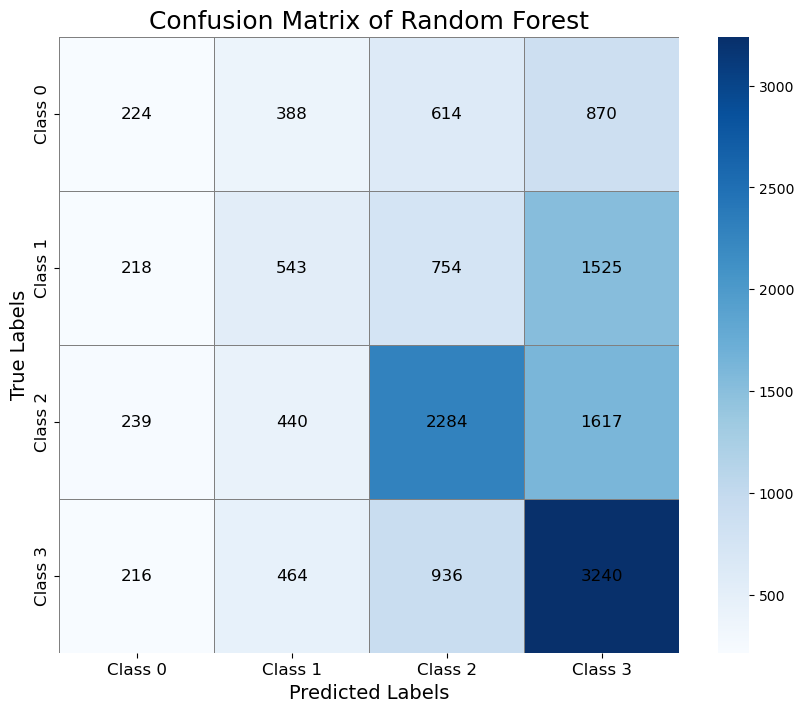

In [16]:
evaluate_model(X_train, y_train, X_test, y_test, 
               model=RandomForestClassifier(n_estimators=100, random_state=42), 
               model_name="Random Forest", use_resampling=False)

### XGBoost


Using original training data (no resampling)...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.4300
Balanced Accuracy: 0.3707
Macro Precision: 0.3730
Macro Recall: 0.3707
Macro F1-Score: 0.3657
Macro AUC-ROC: 0.6779

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.4332
Balanced Accuracy: 0.3703
Macro Precision: 0.3740
Macro Recall: 0.3703
Macro F1 Score: 0.3635
Macro AUC-ROC: 0.6817

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.13      0.17      2096
           1       0.28      0.20      0.24      3040
           2       0.50      0.53      0.51      4580
           3       0.47      0.61      0.53      4856

    accuracy                           0.43     14572
   macro avg       0.37      0.37      0.36     14572
weighted avg       0.41      0.43      0.41     14572



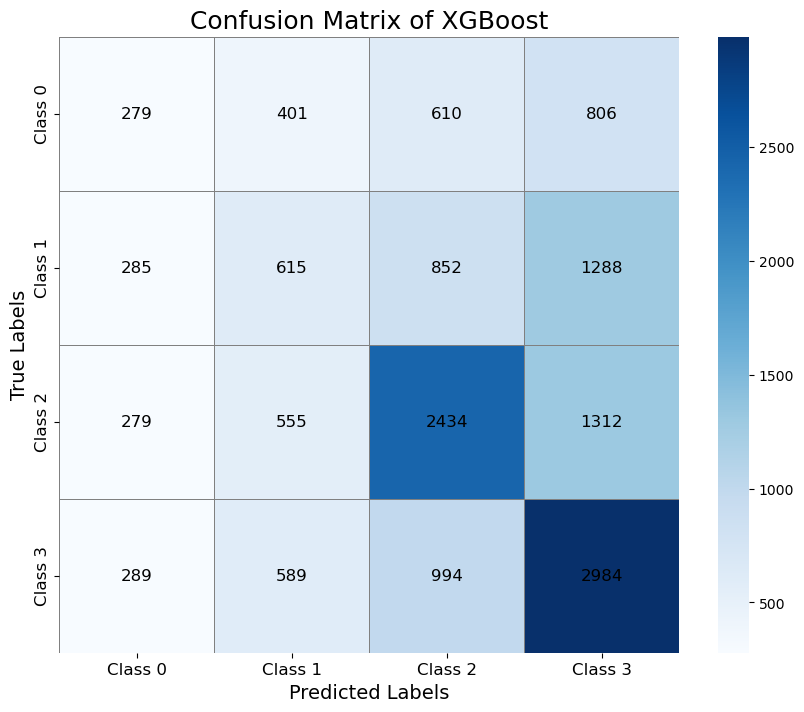

In [17]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
               model=XGBClassifier(n_estimators=100, random_state=42), 
               model_name="XGBoost", use_resampling=False)

### K-Nearest Neighbors


Using original training data (no resampling)...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.3407
Balanced Accuracy: 0.3160
Macro Precision: 0.3161
Macro Recall: 0.3160
Macro F1-Score: 0.3149
Macro AUC-ROC: 0.5798

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.3387
Balanced Accuracy: 0.3156
Macro Precision: 0.3152
Macro Recall: 0.3156
Macro F1 Score: 0.3146
Macro AUC-ROC: 0.5844

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.21      0.20      2096
           1       0.24      0.27      0.26      3040
           2       0.42      0.43      0.43      4580
           3       0.40      0.35      0.37      4856

    accuracy                           0.34     14572
   macro avg       0.32      0.32      0.31     14572
weighted avg       0.35      0.34      0.34     14572



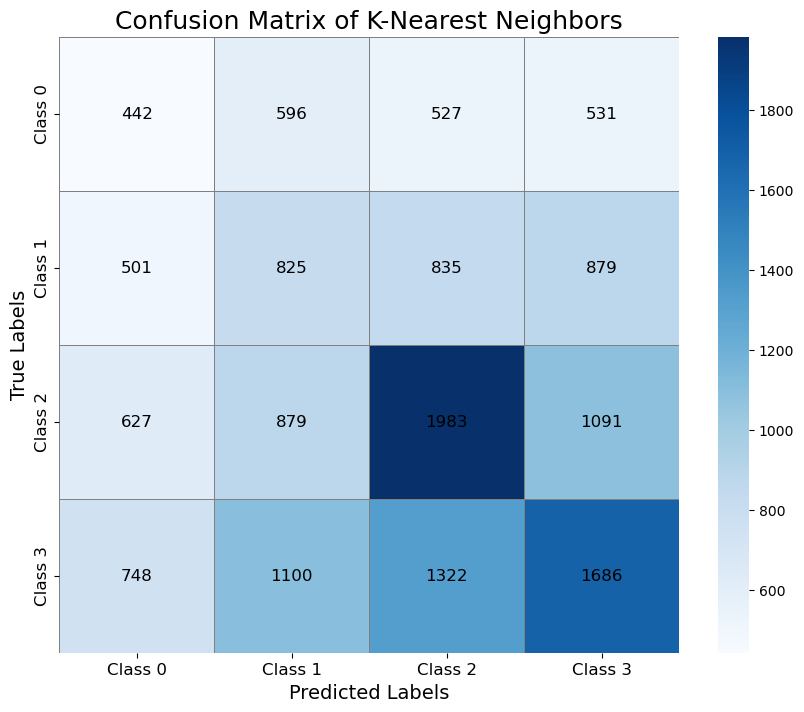

In [18]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
        model=KNeighborsClassifier(n_neighbors=5),  # KNN with 5 neighbors
        model_name="K-Nearest Neighbors", use_resampling=False  
)

## After SMOTE-Tomek

### Random Forest


Applying SMOTE-Tomek for resampling...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.4180
Balanced Accuracy: 0.3781
Macro Precision: 0.3812
Macro Recall: 0.3781
Macro F1-Score: 0.3773
Macro AUC-ROC: 0.6691

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.4259
Balanced Accuracy: 0.3857
Macro Precision: 0.3886
Macro Recall: 0.3857
Macro F1 Score: 0.3852
Macro AUC-ROC: 0.6769

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.25      0.24      2096
           1       0.28      0.26      0.27      3040
           2       0.55      0.46      0.50      4580
           3       0.49      0.57      0.52      4856

    accuracy                           0.43     14572
   macro avg       0.39      0.39      0.39     14572
weighted avg       0.43      0.43      0.42     14572



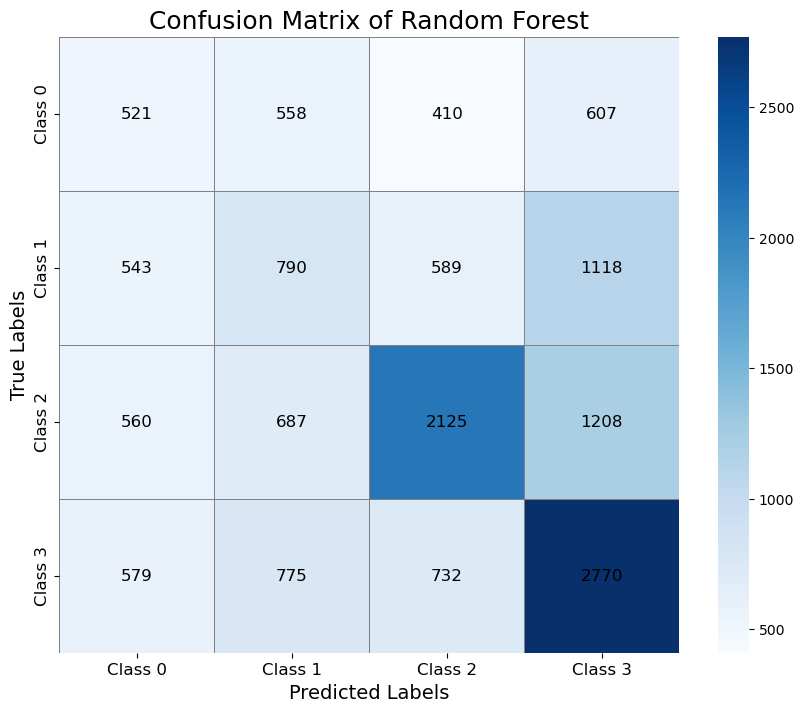

In [19]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
               model=RandomForestClassifier(n_estimators=100, random_state=42), 
               model_name="Random Forest", use_resampling=True)

### XGBoost


Applying SMOTE-Tomek for resampling...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.4239
Balanced Accuracy: 0.3778
Macro Precision: 0.3786
Macro Recall: 0.3778
Macro F1-Score: 0.3773
Macro AUC-ROC: 0.6766

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.4316
Balanced Accuracy: 0.3855
Macro Precision: 0.3878
Macro Recall: 0.3855
Macro F1 Score: 0.3852
Macro AUC-ROC: 0.6829

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.21      0.23      2096
           1       0.29      0.26      0.27      3040
           2       0.54      0.50      0.52      4580
           3       0.48      0.57      0.52      4856

    accuracy                           0.43     14572
   macro avg       0.39      0.39      0.39     14572
weighted avg       0.43      0.43      0.43     14572



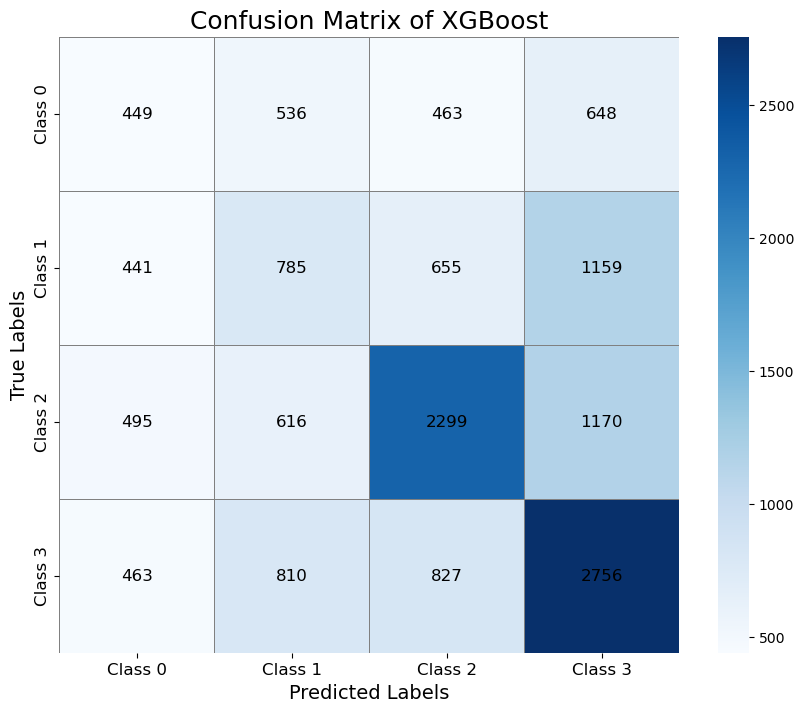

In [20]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
               model=XGBClassifier(n_estimators=100, random_state=42), 
               model_name="XGBoost", use_resampling=True)

### K-Nearest Neighbors


Applying SMOTE-Tomek for resampling...

Performing Cross-Validation...
Cross-Validation Metrics:
Accuracy: 0.2927
Balanced Accuracy: 0.3178
Macro Precision: 0.3426
Macro Recall: 0.3178
Macro F1-Score: 0.2921
Macro AUC-ROC: 0.5728

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.2988
Balanced Accuracy: 0.3246
Macro Precision: 0.3467
Macro Recall: 0.3246
Macro F1 Score: 0.2981
Macro AUC-ROC: 0.5774

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.44      0.25      2096
           1       0.24      0.35      0.29      3040
           2       0.53      0.32      0.40      4580
           3       0.45      0.18      0.26      4856

    accuracy                           0.30     14572
   macro avg       0.35      0.32      0.30     14572
weighted avg       0.39      0.30      0.31     14572



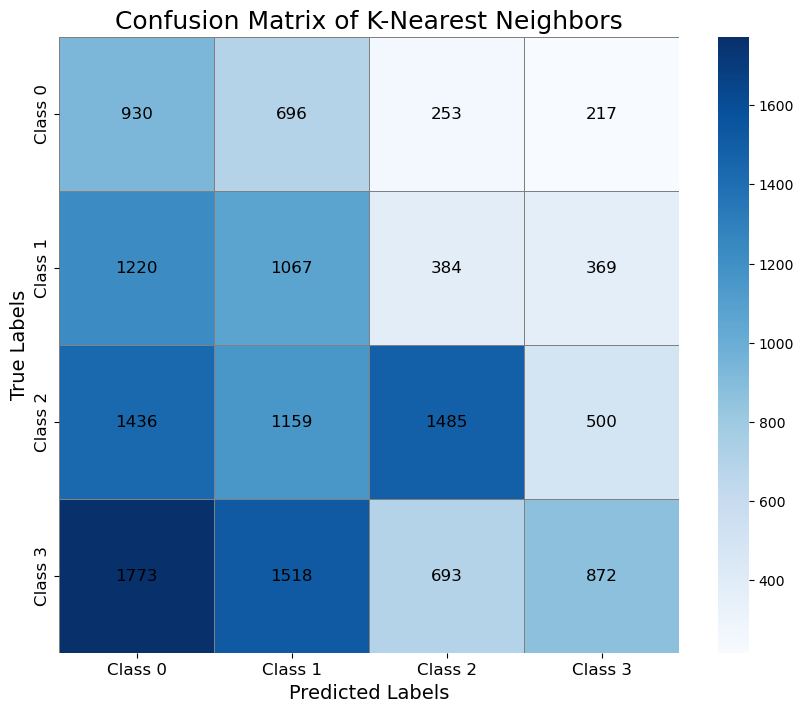

In [21]:
evaluate_model(X_train_selected, y_train, X_test_selected, y_test, 
        model=KNeighborsClassifier(n_neighbors=5), 
        model_name="K-Nearest Neighbors", use_resampling=True)

# Experiemnt 2: transactional data vs combined data

In [22]:
X = data_encoded.drop(columns=['Feedback'])
y = data_encoded['Feedback']

# Split the dataset into training + validation set (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Save column names and indices
X_train_columns = X.columns
X_test_columns = X.columns
X_train_index = X_train.index
X_test_index = X_test.index

# Standardization
scaler = StandardScaler()

# Fit and transform the training set
X_train = scaler.fit_transform(X_train)

# Apply the scaling rules from the training set to the test set
X_test = scaler.transform(X_test)

# Convert back to DataFrame to retain column names and indices
X_train_d = pd.DataFrame(X_train, columns=X_train_columns, index=X_train_index)
X_test_d = pd.DataFrame(X_test, columns=X_test_columns, index=X_test_index)

# Define lists of feature groups
transactional_features = ['Recency', 'Frequency', 'Monetary','Total_Purchases','Amount','Payment_Method','Order_Status','Shipping_Method']  
demographic_features = ['Age', 'Income_encoded', 'Gender', 'Age_Income_Interaction'] 

# select transactional and demographic features
transactional_features_encoded = [col for col in X_train_d.columns if any(feature in col for feature in transactional_features)]
demographic_features_encoded = [col for col in X_train_d.columns if any(feature in col for feature in demographic_features)]

X_train_transactional = X_train_d[transactional_features_encoded]
X_train_combined = X_train_d[transactional_features_encoded + demographic_features_encoded]
X_test_transactional = X_test_d[transactional_features_encoded]
X_test_combined = X_test_d[transactional_features_encoded + demographic_features_encoded]

# Check the resulting datasets
print("X_train_transactional shape:", X_train_transactional.shape)
print("X_train_combined shape:", X_train_combined.shape)
print("X_test_transactional shape:", X_test_transactional.shape)
print("X_test_combined shape:", X_test_combined.shape)


X_train_transactional shape: (34001, 13)
X_train_combined shape: (34001, 16)
X_test_transactional shape: (14572, 13)
X_test_combined shape: (14572, 16)


In [23]:

def evaluate_model_on_datasets(
    model, model_name, X_train_transactional, X_test_transactional, 
    X_train_combined, X_test_combined, y_train, y_test, 
    scoring=None, cv_splits=3, random_state=42
):
    """
    Evaluates a single model on both transactional and combined datasets with cross-validation
    and reports test data performance metrics.

    Parameters:
    - model: The machine learning model to evaluate.
    - model_name: Name of the model (string).
    - X_train_transactional: Training data for the transactional dataset.
    - X_test_transactional: Test data for the transactional dataset.
    - X_train_combined: Training data for the combined dataset.
    - X_test_combined: Test data for the combined dataset.
    - y_train: Training target data.
    - y_test: Test target data.
    - scoring: Dictionary of scoring metrics for cross-validation.
    - cv_splits: Number of folds for cross-validation (default: 3).
    - random_state: Random state for reproducibility (default: 42).

    Returns:
    - A DataFrame containing metrics for both datasets.
    """
    # Define scoring metrics if not provided
    if scoring is None:
        scoring = {
            'accuracy': 'accuracy',
            'balanced_accuracy': make_scorer(balanced_accuracy_score),
            'precision_macro': make_scorer(precision_score, average='macro'),
            'recall_macro': make_scorer(recall_score, average='macro'),
            'f1_macro': make_scorer(f1_score, average='macro'),
            'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)
        }

    # Create StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Helper function for evaluation on a single dataset
    def evaluate_dataset(X_train, X_test, dataset_label):
        print(f"\n=== Evaluating {model_name} on {dataset_label} Dataset ===")
        
        # Create a pipeline with SMOTE-Tomek
        pipeline = Pipeline(steps=[('smote_tomek', SMOTETomek(random_state=random_state)), ('model', model)])
        
        # Perform cross-validation
        print("\nPerforming Cross-Validation...")
        cv_results = cross_validate(pipeline, X_train, y_train, cv=stratified_kfold, scoring=scoring, n_jobs=-1)
        
        # Store cross-validation metrics
        for metric, scores in cv_results.items():
            if metric.startswith('test_'):
                metric_name = metric.replace('test_', '').capitalize()
                mean_score = scores.mean()
                print(f"Cross-Validation {metric_name}: {mean_score:.4f}")
        
        # Train the model on the full training set
        print("\nFitting the model on the full training data...")
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test set
        print("\nEvaluating on the Test Data...")
        y_test_pred = pipeline.predict(X_test)
        y_test_proba = pipeline.predict_proba(X_test)

        # Compute test metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
        test_macro_precision = precision_score(y_test, y_test_pred, average='macro')
        test_macro_recall = recall_score(y_test, y_test_pred, average='macro')
        test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
        test_auc_roc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
        
        # Display test set metrics
        print("\nTest Set Metrics:")
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"Macro Precision: {test_macro_precision:.4f}")
        print(f"Macro Recall: {test_macro_recall:.4f}")
        print(f"Macro F1 Score: {test_macro_f1:.4f}")
        print(f"Macro AUC-ROC: {test_auc_roc:.4f}")

        
        # Print classification report for detailed class-wise analysis
        print("\nTest Set Classification Report:")
        print(classification_report(y_test, y_test_pred))
    
    # Evaluate on Transactional Dataset
    evaluate_dataset(X_train_transactional, X_test_transactional, 'Transactional')
    
    # Evaluate on Combined Dataset
    evaluate_dataset(X_train_combined, X_test_combined, 'Combined')


## Random Forest

In [24]:
evaluate_model_on_datasets(
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    model_name="Random Forest",
    X_train_transactional=X_train_transactional, 
    X_test_transactional=X_test_transactional,
    X_train_combined=X_train_combined, 
    X_test_combined=X_test_combined,
    y_train=y_train, 
    y_test=y_test,
    scoring=None,  
    cv_splits=3,
    random_state=42
)


=== Evaluating Random Forest on Transactional Dataset ===

Performing Cross-Validation...
Cross-Validation Accuracy: 0.2778
Cross-Validation Balanced_accuracy: 0.2611
Cross-Validation Precision_macro: 0.2613
Cross-Validation Recall_macro: 0.2611
Cross-Validation F1_macro: 0.2602
Cross-Validation Roc_auc: 0.5179

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.2823
Balanced Accuracy: 0.2657
Macro Precision: 0.2666
Macro Recall: 0.2657
Macro F1 Score: 0.2648
Macro AUC-ROC: 0.5173

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.19      0.17      2096
           1       0.22      0.23      0.22      3040
           2       0.34      0.32      0.33      4580
           3       0.36      0.32      0.34      4856

    accuracy                           0.28     14572
   macro avg       0.27      0.27      0.26     14572
weighted avg       0.29      0.28      0.

## XGBoost

In [25]:
evaluate_model_on_datasets(
    model=XGBClassifier(n_estimators=100, random_state=42),
    model_name="XGBoost",
    X_train_transactional=X_train_transactional, 
    X_test_transactional=X_test_transactional,
    X_train_combined=X_train_combined, 
    X_test_combined=X_test_combined,
    y_train=y_train, 
    y_test=y_test,
    scoring=None,  
    cv_splits=3,
    random_state=42
)


=== Evaluating XGBoost on Transactional Dataset ===

Performing Cross-Validation...
Cross-Validation Accuracy: 0.3035
Cross-Validation Balanced_accuracy: 0.2702
Cross-Validation Precision_macro: 0.2699
Cross-Validation Recall_macro: 0.2702
Cross-Validation F1_macro: 0.2692
Cross-Validation Roc_auc: 0.5268

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.3153
Balanced Accuracy: 0.2767
Macro Precision: 0.2762
Macro Recall: 0.2767
Macro F1 Score: 0.2745
Macro AUC-ROC: 0.5328

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.11      0.13      2096
           1       0.22      0.20      0.21      3040
           2       0.36      0.42      0.38      4580
           3       0.37      0.38      0.37      4856

    accuracy                           0.32     14572
   macro avg       0.28      0.28      0.27     14572
weighted avg       0.30      0.32      0.31    

## K-Nearest Neighbors

In [26]:
evaluate_model_on_datasets(
    model=KNeighborsClassifier(n_neighbors=5),
    model_name="K-Nearest Neighbors",
    X_train_transactional=X_train_transactional, 
    X_test_transactional=X_test_transactional,
    X_train_combined=X_train_combined, 
    X_test_combined=X_test_combined,
    y_train=y_train, 
    y_test=y_test,
    scoring=None,  
    cv_splits=3,
    random_state=42
)


=== Evaluating K-Nearest Neighbors on Transactional Dataset ===

Performing Cross-Validation...
Cross-Validation Accuracy: 0.2350
Cross-Validation Balanced_accuracy: 0.2565
Cross-Validation Precision_macro: 0.2589
Cross-Validation Recall_macro: 0.2565
Cross-Validation F1_macro: 0.2341
Cross-Validation Roc_auc: 0.5099

Fitting the model on the full training data...

Evaluating on the Test Data...

Test Set Metrics:
Accuracy: 0.2348
Balanced Accuracy: 0.2572
Macro Precision: 0.2609
Macro Recall: 0.2572
Macro F1 Score: 0.2343
Macro AUC-ROC: 0.5101

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.35      0.20      2096
           1       0.21      0.30      0.25      3040
           2       0.34      0.22      0.27      4580
           3       0.35      0.16      0.22      4856

    accuracy                           0.23     14572
   macro avg       0.26      0.26      0.23     14572
weighted avg       0.29      0.23  

# Hyperparameter Tuning 

In [27]:
import re
def optimize_and_evaluate_model(
    X_train, y_train, X_test, y_test, model, param_space,  model_name="Model",
    scoring=make_scorer(f1_score, average='macro'), 
    cv_splits=3, n_iter=30, random_state=42, use_resampling=False
):
    """
    Optimizes hyperparameters of a given model using Bayesian optimization
    and evaluates its performance on both cross-validation and test data.

    Parameters:
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_test: Test feature data.
    - y_test: Test target data.
    - model: Machine learning model (e.g., LogisticRegression, RandomForest).
    - param_space: Parameter space for Bayesian optimization.
    - scoring: Scoring metric for optimization (default: Macro F1 Score).
    - cv_splits: Number of folds for cross-validation (default: 3).
    - n_iter: Number of iterations for Bayesian search (default: 30).
    - random_state: Random state for reproducibility (default: 42).
    - use_resampling: Boolean to indicate whether to apply SMOTE-Tomek (default: False).

    Returns:
    - None (prints metrics and plots confusion matrix).
    """
    # Create StratifiedKFold cross-validation object
    stratified_kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create a pipeline (optionally include SMOTE-Tomek)
    if use_resampling:
        print("\nApplying SMOTE-Tomek for resampling...")
        pipeline = Pipeline(steps=[('smote_tomek', SMOTETomek(random_state=random_state)), ('model', model)])
    else:
        print("\nUsing original training data (no resampling)...")
        pipeline = Pipeline(steps=[('model', model)])
    
    # Initialize Bayesian search
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        scoring=scoring,
        cv=stratified_kfold,
        n_iter=n_iter,
        n_jobs=-1,
        random_state=random_state
    )
    
    # Fit Bayesian search
    print("\nStarting hyperparameter optimization...")
    bayes_search.fit(X_train, y_train)
    
    # Best parameters and performance
    print("\nOptimization Results:")
    print("Best Parameters:", bayes_search.best_params_)
    print(f"Best Score from Cross-Validation ({scoring._score_func.__name__}): {bayes_search.best_score_:.4f}")
    
    # Evaluate the best model on the test set
    best_model = bayes_search.best_estimator_
    print("\nEvaluating the optimized model on the Test Data...")
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)
    
    # Compute metrics on the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    test_macro_precision = precision_score(y_test, y_test_pred, average='macro')
    test_macro_recall = recall_score(y_test, y_test_pred, average='macro')
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_auc_roc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
    
    # Print test set metrics
    print("\nTest Set Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Balanced Accuracy: {test_balanced_accuracy:.4f}")
    print(f"Macro Precision: {test_macro_precision:.4f}")
    print(f"Macro Recall: {test_macro_recall:.4f}")
    print(f"Macro F1 Score: {test_macro_f1:.4f}")
    print(f"Macro AUC-ROC: {test_auc_roc:.4f}")
    
    # Print classification report for class-wise analysis
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    labels = [f"Class {i}" for i in range(len(conf_matrix))]  # Adjust labels dynamically based on class count
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 12, "weight": "normal", "color": "black"})
    plt.title(f"Confusion Matrix of {model_name} after Tuning", fontsize=18)  # Title size
    plt.xlabel("Predicted Labels", fontsize=14)  # X-axis label size
    plt.ylabel("True Labels", fontsize=14)  # Y-axis label size
    plt.xticks(fontsize=12)  # X-axis tick size
    plt.yticks(fontsize=12)  # Y-axis tick size
    plt.savefig(f"confusion_matrix_tuning_{model_name}.png", dpi=300)
    plt.show()
    


## Imbalanced data

### Random Forest


Using original training data (no resampling)...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__bootstrap', True), ('model__max_depth', 30), ('model__max_features', None), ('model__min_samples_leaf', 5), ('model__min_samples_split', 10), ('model__n_estimators', 50)])
Best Score from Cross-Validation (f1_score): 0.3589

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4368
Balanced Accuracy: 0.3721
Macro Precision: 0.3781
Macro Recall: 0.3721
Macro F1 Score: 0.3648
Macro AUC-ROC: 0.6853

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.12      0.16      2096
           1       0.29      0.21      0.25      3040
           2       0.51      0.54      0.53      4580
           3       0.46      0.62      0.53      4856

    accuracy                           0.44     14572
   macro avg       0.38      0.37      0.36     14572
weighte

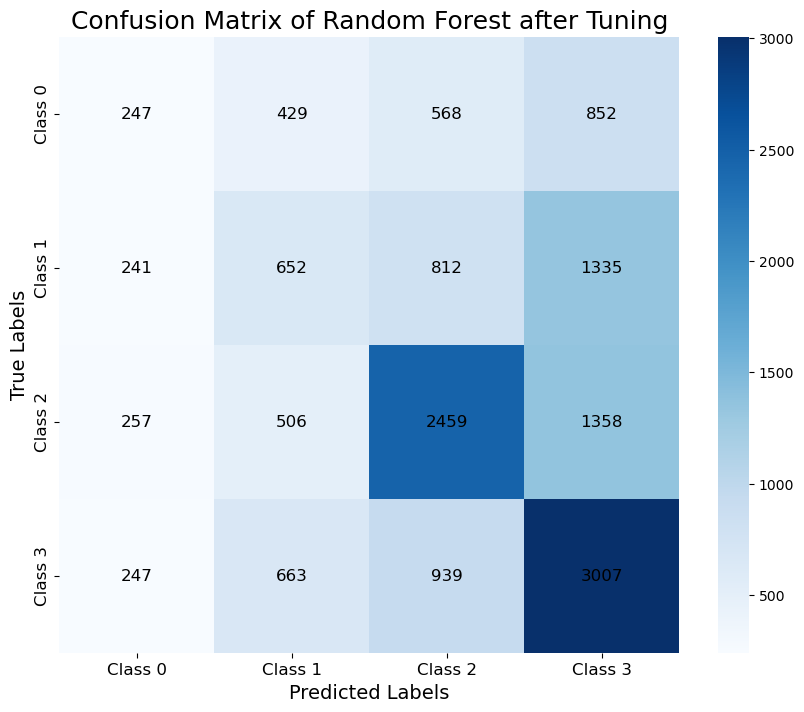

In [28]:
# Define the parameter space
param_space = {
    'model__n_estimators': (50, 500),              # Number of trees in the forest
    'model__max_depth': (5, 30),                   # Maximum depth of the tree
    'model__min_samples_split': (2, 10),           # Minimum samples to split a node
    'model__min_samples_leaf': (1, 5),             # Minimum samples per leaf
    'model__max_features': ['sqrt', 'log2', None], # Number of features to consider for the best split
    'model__bootstrap': [True, False]              # Use bootstrap or not
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=RandomForestClassifier(random_state=42),
    param_space=param_space,
    model_name="Random Forest",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=False
)


### XGBoost


Using original training data (no resampling)...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__colsample_bytree', 0.8), ('model__gamma', 1), ('model__learning_rate', 0.046838210436453864), ('model__max_depth', 15), ('model__n_estimators', 1200), ('model__reg_alpha', 1), ('model__reg_lambda', 3), ('model__subsample', 0.5)])
Best Score from Cross-Validation (f1_score): 0.3648

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4362
Balanced Accuracy: 0.3738
Macro Precision: 0.3778
Macro Recall: 0.3738
Macro F1 Score: 0.3675
Macro AUC-ROC: 0.6844

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.13      0.17      2096
           1       0.30      0.21      0.25      3040
           2       0.51      0.54      0.52      4580
           3       0.47      0.61      0.53      4856

    accuracy                           0.44     14572
   

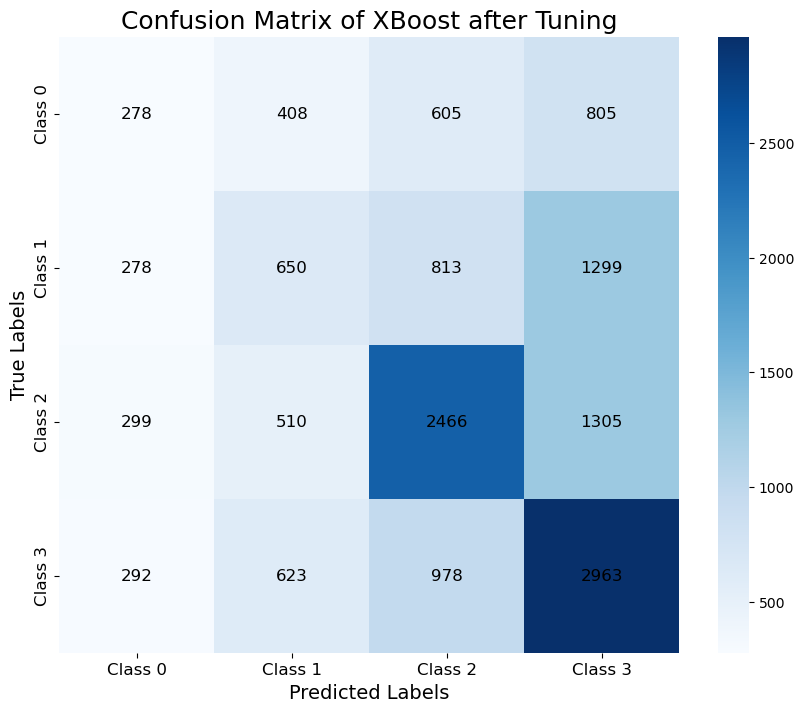

In [37]:
param_space = {
    'model__n_estimators': (500, 1200),  
    'model__max_depth': (3, 15),  
    'model__learning_rate': (0.001, 0.1, 'log-uniform'),  
    'model__colsample_bytree': (0.3, 0.8),  
    'model__subsample': (0.5, 1.0),  
    'model__gamma': (0, 5),  
    'model__reg_alpha': (0, 1),  
    'model__reg_lambda': (1, 3)  
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=XGBClassifier(random_state=42),
    param_space=param_space,
    model_name="XBoost",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=False
)

### K_Nearest Neighbors


Using original training data (no resampling)...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__algorithm', 'auto'), ('model__leaf_size', 50), ('model__metric', 'manhattan'), ('model__n_neighbors', 19), ('model__p', 1), ('model__weights', 'uniform')])
Best Score from Cross-Validation (f1_score): 0.3310

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.3837
Balanced Accuracy: 0.3340
Macro Precision: 0.3389
Macro Recall: 0.3340
Macro F1 Score: 0.3311
Macro AUC-ROC: 0.6142

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.13      0.17      2096
           1       0.27      0.22      0.24      3040
           2       0.45      0.44      0.44      4580
           3       0.42      0.54      0.47      4856

    accuracy                           0.38     14572
   macro avg       0.34      0.33      0.33     14572
weighted avg       0.37

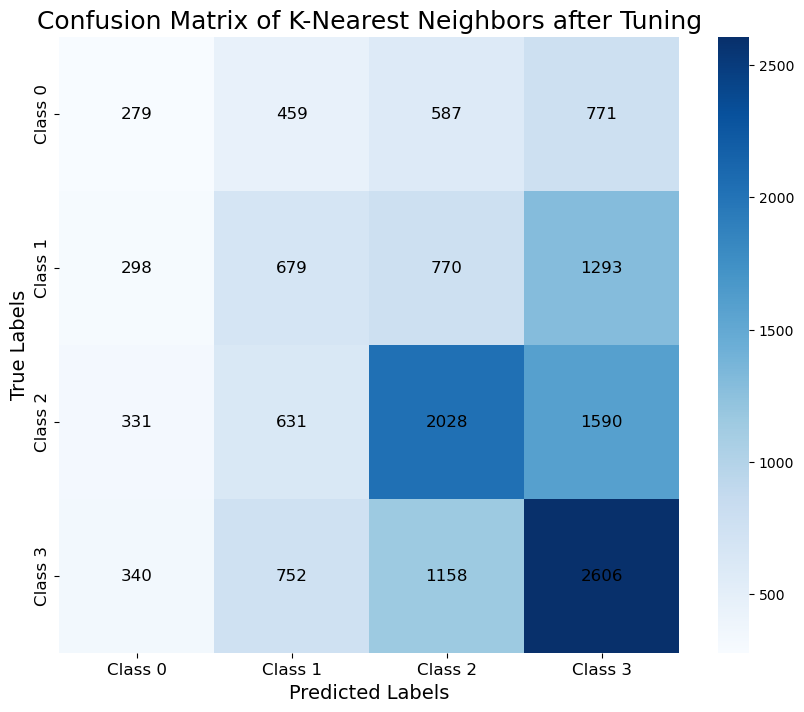

In [30]:
param_space = {
    'model__n_neighbors': (1, 50),  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weighting scheme
    'model__p': (1, 2),  # Minkowski distance metric
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Nearest neighbor search algorithm
    'model__leaf_size': (10, 50),  # Leaf size for KDTree or BallTree
    'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']  # Distance metrics
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=KNeighborsClassifier(),
    param_space=param_space,
    model_name="K-Nearest Neighbors",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=False
)

## Resampled data

### Random Forest


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__bootstrap', True), ('model__max_depth', 12), ('model__max_features', None), ('model__min_samples_leaf', 5), ('model__min_samples_split', 10), ('model__n_estimators', 500)])
Best Score from Cross-Validation (f1_score): 0.4044

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4282
Balanced Accuracy: 0.4225
Macro Precision: 0.4333
Macro Recall: 0.4225
Macro F1 Score: 0.4094
Macro AUC-ROC: 0.6941

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.51      0.32      2096
           1       0.29      0.25      0.27      3040
           2       0.66      0.46      0.54      4580
           3       0.55      0.48      0.51      4856

    accuracy                           0.43     14572
   macro avg       0.43      0.42      0.41     14572
weighted avg   

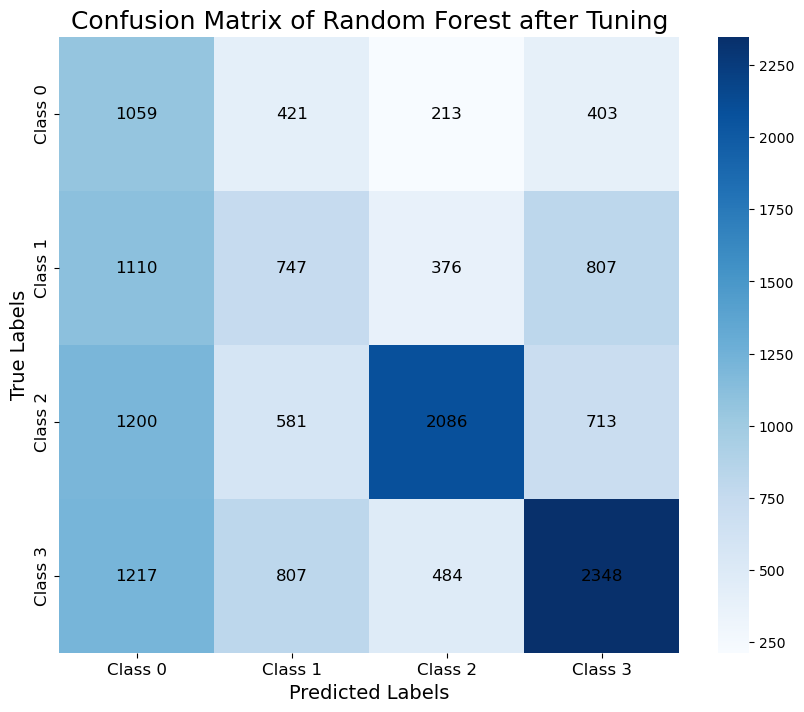

In [35]:
# Define the parameter space
param_space = {
    'model__n_estimators': (50, 500),              # Number of trees in the forest
    'model__max_depth': (5, 30),                   # Maximum depth of the tree
    'model__min_samples_split': (2, 10),           # Minimum samples to split a node
    'model__min_samples_leaf': (1, 5),             # Minimum samples per leaf
    'model__max_features': ['sqrt', 'log2', None], # Number of features to consider for the best split
    'model__bootstrap': [True, False]              # Use bootstrap or not
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=RandomForestClassifier(random_state=42),
    param_space=param_space,
    model_name="Random Forest",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)


### XGBoost


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__colsample_bytree', 0.8), ('model__gamma', 5), ('model__learning_rate', 0.025054430527964595), ('model__max_depth', 15), ('model__n_estimators', 546), ('model__reg_alpha', 0), ('model__reg_lambda', 2), ('model__subsample', 1.0)])
Best Score from Cross-Validation (f1_score): 0.4109

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4392
Balanced Accuracy: 0.4169
Macro Precision: 0.4262
Macro Recall: 0.4169
Macro F1 Score: 0.4143
Macro AUC-ROC: 0.6938

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.37      0.29      2096
           1       0.29      0.30      0.30      3040
           2       0.64      0.47      0.54      4580
           3       0.54      0.53      0.53      4856

    accuracy                           0.44     14572
   macro avg 

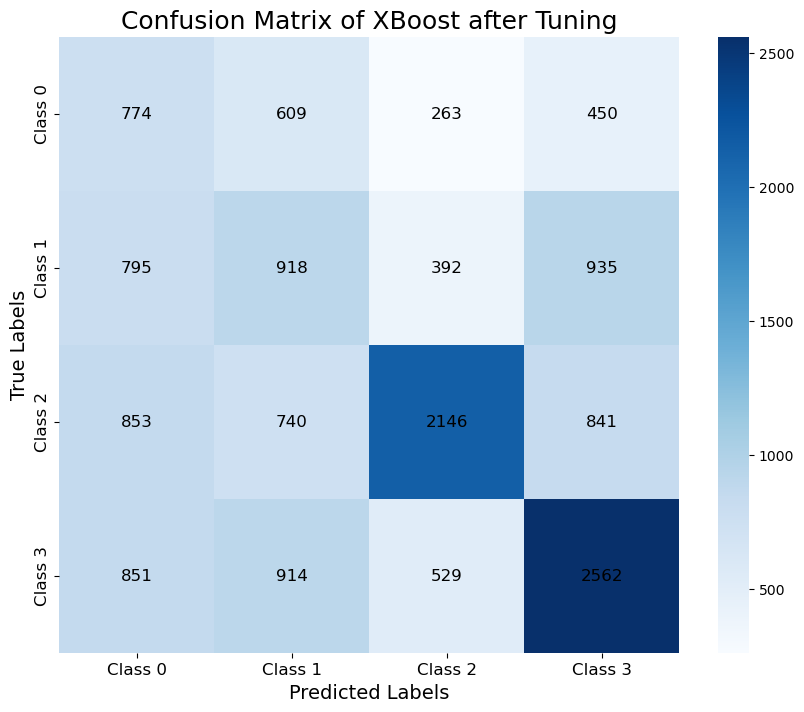

In [39]:
param_space = {
    'model__n_estimators': (500, 1200),  
    'model__max_depth': (3, 15),  
    'model__learning_rate': (0.001, 0.1, 'log-uniform'),  
    'model__colsample_bytree': (0.3, 0.8),  
    'model__subsample': (0.5, 1.0),  
    'model__gamma': (0, 5),  
    'model__reg_alpha': (0, 1),  
    'model__reg_lambda': (1, 3)  
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=XGBClassifier(random_state=42),
    param_space=param_space,
    model_name="XBoost",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__colsample_bytree', 1.0), ('model__gamma', 3), ('model__learning_rate', 0.01), ('model__max_depth', 10), ('model__n_estimators', 100), ('model__reg_alpha', 0), ('model__reg_lambda', 2), ('model__subsample', 0.5)])
Best Score from Cross-Validation (f1_score): 0.4105

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4325
Balanced Accuracy: 0.4252
Macro Precision: 0.4318
Macro Recall: 0.4252
Macro F1 Score: 0.4137
Macro AUC-ROC: 0.7025

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.49      0.32      2096
           1       0.28      0.26      0.27      3040
           2       0.63      0.48      0.55      4580
           3       0.58      0.47      0.52      4856

    accuracy                           0.43     14572
   macro avg       0.43      

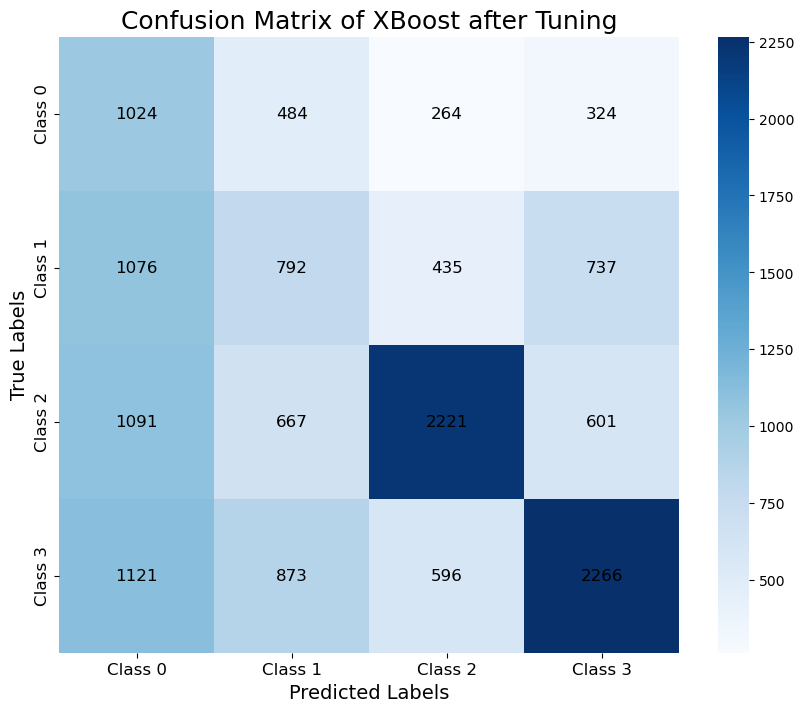

In [53]:
param_space = {
    'model__n_estimators': (100, 1000),
    'model__max_depth': (3, 15),
    'model__learning_rate': (0.01, 0.1, 'log-uniform'),
    'model__colsample_bytree': (0.3, 1.0),
    'model__subsample': (0.5, 1.0),
    'model__gamma': (0, 3),
    'model__reg_alpha': (0, 1),
    'model__reg_lambda': (1, 5)
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=XGBClassifier(random_state=42),
    param_space=param_space,
    model_name="XBoost",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)

### K-Nearest Neighbors


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__algorithm', 'brute'), ('model__leaf_size', 50), ('model__metric', 'manhattan'), ('model__n_neighbors', 46), ('model__p', 2), ('model__weights', 'distance')])
Best Score from Cross-Validation (f1_score): 0.3378

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.3466
Balanced Accuracy: 0.3500
Macro Precision: 0.3685
Macro Recall: 0.3500
Macro F1 Score: 0.3399
Macro AUC-ROC: 0.6184

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.40      0.26      2096
           1       0.26      0.31      0.28      3040
           2       0.57      0.32      0.41      4580
           3       0.46      0.37      0.41      4856

    accuracy                           0.35     14572
   macro avg       0.37      0.35      0.34     14572
weighted avg       0.41      0

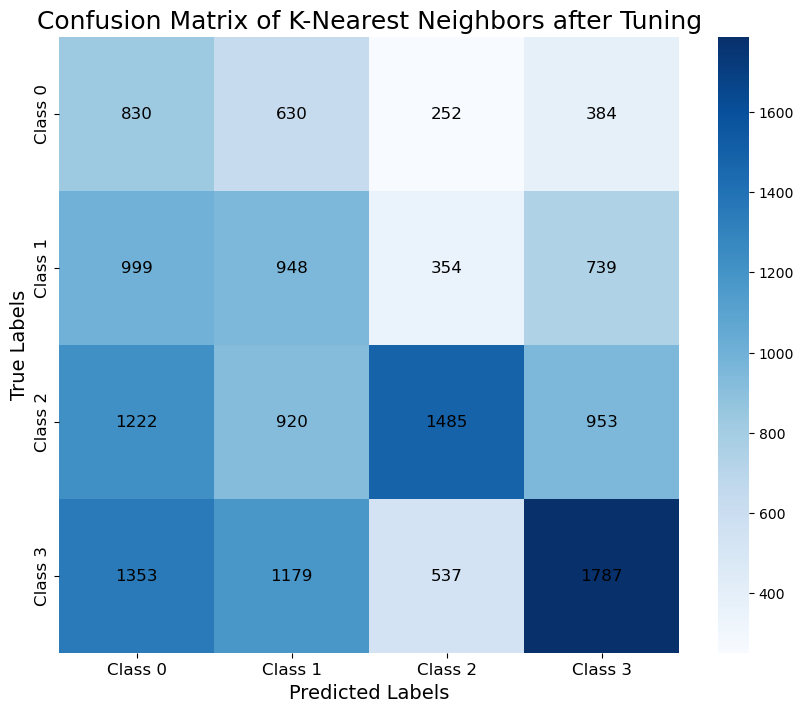

In [36]:
param_space = {
    'model__n_neighbors': (1, 50),  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weighting scheme
    'model__p': (1, 2),  # Minkowski distance metric
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Nearest neighbor search algorithm
    'model__leaf_size': (10, 50),  # Leaf size for KDTree or BallTree
    'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']  # Distance metrics
}

optimize_and_evaluate_model(
    X_train=X_train_selected, 
    y_train=y_train, 
    X_test=X_test_selected, 
    y_test=y_test,
    model=KNeighborsClassifier(),
    param_space=param_space,
    model_name="K-Nearest Neighbors",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)

## Transactional data

### Random Forest


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__bootstrap', True), ('model__max_depth', 17), ('model__max_features', None), ('model__min_samples_leaf', 1), ('model__min_samples_split', 10), ('model__n_estimators', 331)])
Best Score from Cross-Validation (f1_score): 0.2687

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.3019
Balanced Accuracy: 0.2777
Macro Precision: 0.2770
Macro Recall: 0.2777
Macro F1 Score: 0.2743
Macro AUC-ROC: 0.5310

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.18      0.17      2096
           1       0.23      0.21      0.22      3040
           2       0.35      0.45      0.40      4580
           3       0.36      0.28      0.31      4856

    accuracy                           0.30     14572
   macro avg       0.28      0.28      0.27     14572
weighted avg   

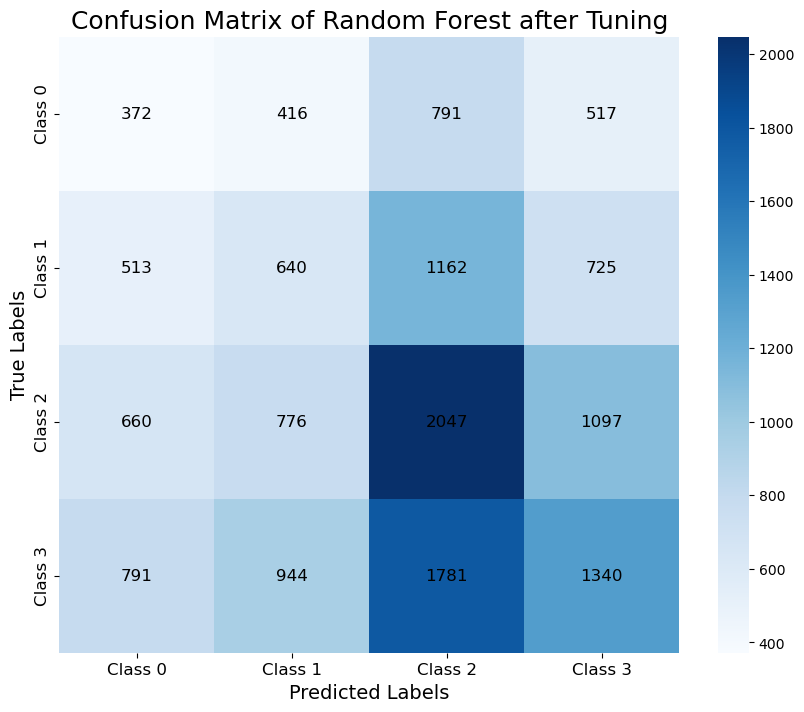

In [56]:
# Define the parameter space
param_space = {
    'model__n_estimators': (50, 500),              # Number of trees in the forest
    'model__max_depth': (5, 30),                   # Maximum depth of the tree
    'model__min_samples_split': (2, 10),           # Minimum samples to split a node
    'model__min_samples_leaf': (1, 5),             # Minimum samples per leaf
    'model__max_features': ['sqrt', 'log2', None], # Number of features to consider for the best split
    'model__bootstrap': [True, False]              # Use bootstrap or not
}

optimize_and_evaluate_model(
    X_train=X_train_transactional, 
    y_train=y_train, 
    X_test=X_test_transactional, 
    y_test=y_test,
    model=RandomForestClassifier(random_state=42),
    param_space=param_space,
    model_name="Random Forest",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)


### XGBoost


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__colsample_bytree', 0.7194639711819282), ('model__gamma', 1), ('model__learning_rate', 0.029634289645104377), ('model__max_depth', 3), ('model__n_estimators', 633), ('model__reg_alpha', 1), ('model__reg_lambda', 1), ('model__subsample', 0.5723215389234919)])
Best Score from Cross-Validation (f1_score): 0.2836

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.3175
Balanced Accuracy: 0.2863
Macro Precision: 0.2881
Macro Recall: 0.2863
Macro F1 Score: 0.2820
Macro AUC-ROC: 0.5441

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.10      0.13      2096
           1       0.23      0.29      0.26      3040
           2       0.37      0.43      0.40      4580
           3       0.38      0.32      0.34      4856

    accuracy                          

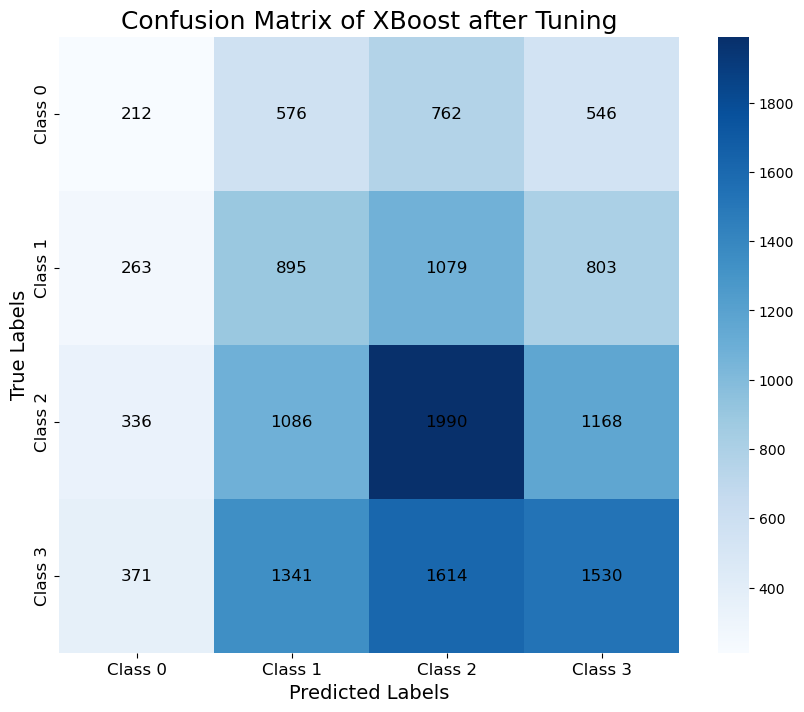

In [40]:
param_space = {
    'model__n_estimators': (500, 1200),  
    'model__max_depth': (3, 15),  
    'model__learning_rate': (0.001, 0.1, 'log-uniform'),  
    'model__colsample_bytree': (0.3, 0.8),  
    'model__subsample': (0.5, 1.0),  
    'model__gamma': (0, 5),  
    'model__reg_alpha': (0, 1),  
    'model__reg_lambda': (1, 3)  
}

optimize_and_evaluate_model(
    X_train=X_train_transactional, 
    y_train=y_train, 
    X_test=X_test_transactional, 
    y_test=y_test,
    model=XGBClassifier(random_state=42),
    param_space=param_space,
    model_name="XBoost",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)

### K-Nearest Neighbors


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__algorithm', 'brute'), ('model__leaf_size', 22), ('model__metric', 'manhattan'), ('model__n_neighbors', 1), ('model__p', 1), ('model__weights', 'distance')])
Best Score from Cross-Validation (f1_score): 0.2602

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.2698
Balanced Accuracy: 0.2555
Macro Precision: 0.2564
Macro Recall: 0.2555
Macro F1 Score: 0.2543
Macro AUC-ROC: 0.5041

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.19      0.16      2096
           1       0.21      0.23      0.22      3040
           2       0.33      0.29      0.31      4580
           3       0.34      0.31      0.32      4856

    accuracy                           0.27     14572
   macro avg       0.26      0.26      0.25     14572
weighted avg       0.28      0.

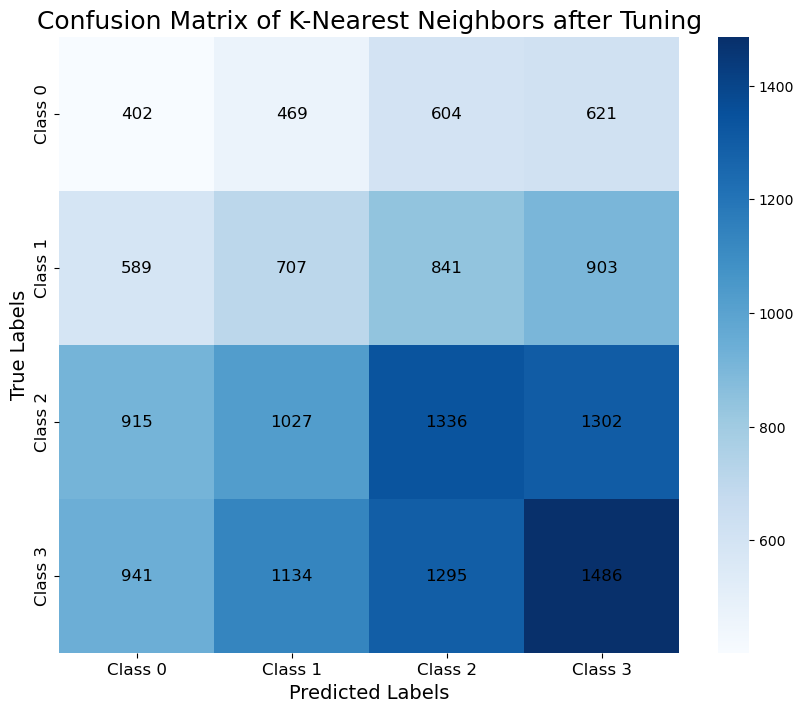

In [58]:
param_space = {
    'model__n_neighbors': (1, 50),  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weighting scheme
    'model__p': (1, 2),  # Minkowski distance metric
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Nearest neighbor search algorithm
    'model__leaf_size': (10, 50),  # Leaf size for KDTree or BallTree
    'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']  # Distance metrics
}

optimize_and_evaluate_model(
    X_train=X_train_transactional, 
    y_train=y_train, 
    X_test=X_test_transactional, 
    y_test=y_test,
    model=KNeighborsClassifier(),
    param_space=param_space,
    model_name="K-Nearest Neighbors",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)

## Combinaed data

### Random Forest


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__bootstrap', True), ('model__max_depth', 30), ('model__max_features', 'log2'), ('model__min_samples_leaf', 5), ('model__min_samples_split', 2), ('model__n_estimators', 500)])
Best Score from Cross-Validation (f1_score): 0.3777

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4026
Balanced Accuracy: 0.3892
Macro Precision: 0.3923
Macro Recall: 0.3892
Macro F1 Score: 0.3817
Macro AUC-ROC: 0.6648

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.40      0.29      2096
           1       0.26      0.25      0.26      3040
           2       0.52      0.47      0.50      4580
           3       0.56      0.43      0.49      4856

    accuracy                           0.40     14572
   macro avg       0.39      0.39      0.38     14572
weighted avg  

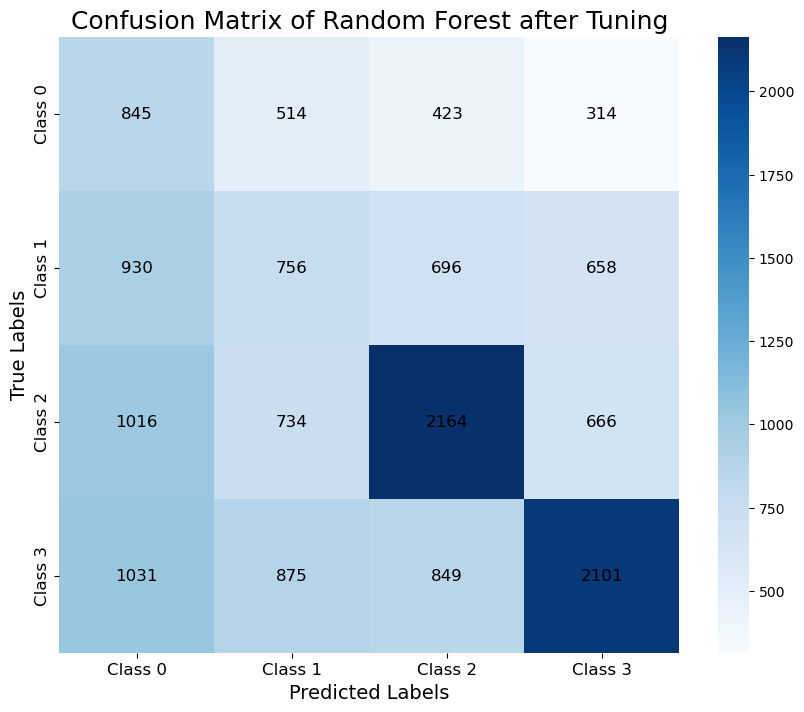

In [59]:
# Define the parameter space
param_space = {
    'model__n_estimators': (50, 500),              # Number of trees in the forest
    'model__max_depth': (5, 30),                   # Maximum depth of the tree
    'model__min_samples_split': (2, 10),           # Minimum samples to split a node
    'model__min_samples_leaf': (1, 5),             # Minimum samples per leaf
    'model__max_features': ['sqrt', 'log2', None], # Number of features to consider for the best split
    'model__bootstrap': [True, False]              # Use bootstrap or not
}

optimize_and_evaluate_model(
    X_train=X_train_combined, 
    y_train=y_train, 
    X_test=X_test_combined, 
    y_test=y_test,
    model=RandomForestClassifier(random_state=42),
    param_space=param_space,
    model_name="Random Forest",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)


### XGBoost


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__colsample_bytree', 0.8), ('model__gamma', 3), ('model__learning_rate', 0.1), ('model__max_depth', 15), ('model__n_estimators', 1161), ('model__reg_alpha', 0), ('model__reg_lambda', 3), ('model__subsample', 0.9898543699387463)])
Best Score from Cross-Validation (f1_score): 0.3862

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.4078
Balanced Accuracy: 0.3927
Macro Precision: 0.3950
Macro Recall: 0.3927
Macro F1 Score: 0.3865
Macro AUC-ROC: 0.6745

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.39      0.29      2096
           1       0.26      0.26      0.26      3040
           2       0.53      0.48      0.50      4580
           3       0.56      0.44      0.49      4856

    accuracy                           0.41     14572
   macro avg  

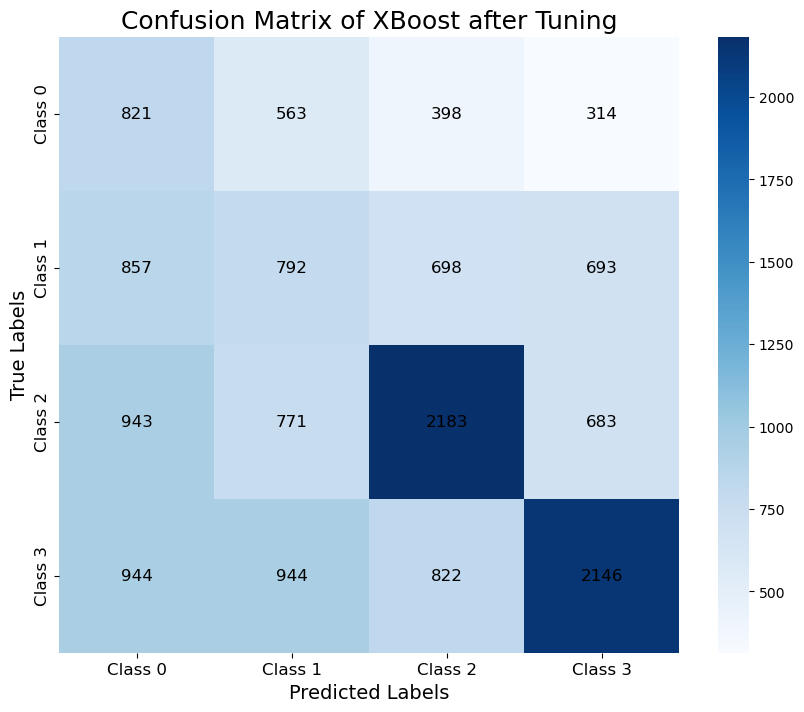

In [41]:
param_space = {
    'model__n_estimators': (500, 1200),  
    'model__max_depth': (3, 15),  
    'model__learning_rate': (0.001, 0.1, 'log-uniform'),  
    'model__colsample_bytree': (0.3, 0.8),  
    'model__subsample': (0.5, 1.0),  
    'model__gamma': (0, 5),  
    'model__reg_alpha': (0, 1),  
    'model__reg_lambda': (1, 3)  
}


optimize_and_evaluate_model(
    X_train=X_train_combined, 
    y_train=y_train, 
    X_test=X_test_combined, 
    y_test=y_test,
    model=XGBClassifier(random_state=42),
    param_space=param_space,
    model_name="XBoost",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)

### K-Nearest Neighbors


Applying SMOTE-Tomek for resampling...

Starting hyperparameter optimization...

Optimization Results:
Best Parameters: OrderedDict([('model__algorithm', 'ball_tree'), ('model__leaf_size', 14), ('model__metric', 'manhattan'), ('model__n_neighbors', 50), ('model__p', 1), ('model__weights', 'distance')])
Best Score from Cross-Validation (f1_score): 0.3072

Evaluating the optimized model on the Test Data...

Test Set Metrics:
Accuracy: 0.3216
Balanced Accuracy: 0.3367
Macro Precision: 0.3487
Macro Recall: 0.3367
Macro F1 Score: 0.3179
Macro AUC-ROC: 0.5965

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.45      0.26      2096
           1       0.25      0.30      0.27      3040
           2       0.43      0.25      0.32      4580
           3       0.52      0.34      0.42      4856

    accuracy                           0.32     14572
   macro avg       0.35      0.34      0.32     14572
weighted avg       0.39   

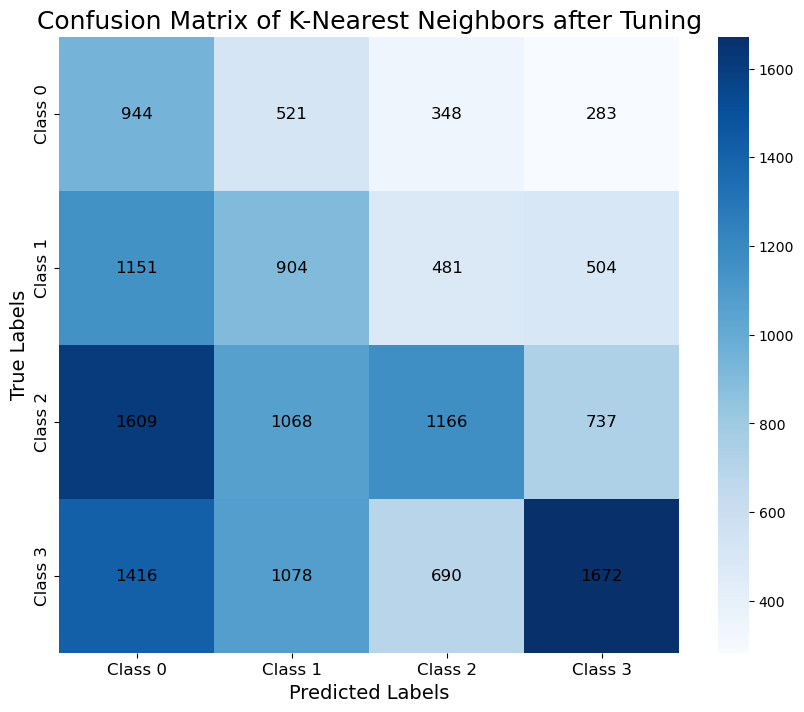

In [61]:
param_space = {
    'model__n_neighbors': (1, 50),  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weighting scheme
    'model__p': (1, 2),  # Minkowski distance metric
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Nearest neighbor search algorithm
    'model__leaf_size': (10, 50),  # Leaf size for KDTree or BallTree
    'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']  # Distance metrics
}

optimize_and_evaluate_model(
    X_train=X_train_combined, 
    y_train=y_train, 
    X_test=X_test_combined, 
    y_test=y_test,
    model=KNeighborsClassifier(),
    param_space=param_space,
    model_name="K-Nearest Neighbors",
    scoring=make_scorer(f1_score, average='macro'), 
    n_iter=30,
    use_resampling=True
)